<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/others/devfolio_oracleofdelphi/notebooks/00_eda_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#Utils
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

#Data analysis
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Reproducibility
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
#Modeling
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [ ]:
#Data
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/others/devfolio_oracleofdelphi/data'
train = pd.read_csv(f'{DATA_URL}/train.csv')
test = pd.read_csv(f'{DATA_URL}/test.csv')

# Data Overview

In [ ]:
train.head()

,Unnamed: 0,Unnamed: 0.1,Monthly_Inhand_Salary,Accounts of user,Credit cards user have,Interest Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Utlization Ratio,Credit Inquiries,Cumulative Balance,Cash Flow,Credit Score
0,5279,5279,4377.0725,10,6,27,6,35,18,16.66,2950.80,154.1724,301.5938,271.9410,76,15,4009,4251,Best
1,473,473,2184.5767,8,6,32,7,51,19,25.17,2989.13,132.4811,71.0167,294.9598,75,19,2425,1073,Best
2,1355,1355,1837.0842,3,7,3,2,14,8,3.37,1336.73,26.7467,31.0273,375.9344,94,0,1731,3322,Good
3,1546,1546,6867.9517,5,4,9,1,6,12,10.36,625.32,66.4577,176.2674,704.0701,86,8,1984,1614,Standard
4,1323,1323,1089.8588,4,7,4,2,12,5,11.90,1439.09,14.3501,50.8404,303.7954,93,0,2765,3986,Good


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6094 entries, 0 to 6093
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               6094 non-null   int64  
 1   Unnamed: 0.1             6094 non-null   int64  
 2   Monthly_Inhand_Salary    6094 non-null   float64
 3   Accounts of user         6094 non-null   int64  
 4   Credit cards user have   6094 non-null   int64  
 5   Interest Rate            6094 non-null   int64  
 6   Num_of_Loan              6094 non-null   int64  
 7   Delay_from_due_date      6094 non-null   int64  
 8   Num_of_Delayed_Payment   6094 non-null   int64  
 9   Changed_Credit_Limit     6094 non-null   float64
 10  Outstanding_Debt         6094 non-null   float64
 11  Total_EMI_per_month      6094 non-null   float64
 12  Amount_invested_monthly  6094 non-null   float64
 13  Monthly_Balance          6094 non-null   float64
 14  Utlization Ratio        

In [ ]:
train.shape, test.shape

((6094, 19), (1524, 18))

In [ ]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

No missing values.

In [ ]:
train = train.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
test = test.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

### Target

In [ ]:
TARGET = 'Credit Score'

In [ ]:
train[TARGET].value_counts(normalize=True)

Best        0.6536
Standard    0.2253
Good        0.1211
Name: Credit Score, dtype: float64

In [ ]:
label_mapping = {'Standard': 0, 'Good': 1, 'Best': 2}
train[TARGET] = train[TARGET].replace(label_mapping)

In [ ]:
features = list(test.columns)

# Adversarial validation

In [ ]:
train['set'] = 0
test['set'] = 1
composite = pd.concat([train, test], axis=0, ignore_index=True)

In [ ]:
composite = composite.drop(TARGET, axis=1)
train = train.drop('set', axis=1)
test = test.drop('set', axis=1)

In [ ]:
%%time
X, y = composite[features], composite['set']
scores = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = ExtraTreesClassifier(
        n_estimators=150,  
        max_depth=7,
        n_jobs=-1, 
        random_state=SEED
    )
    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: {score:.5f}')
    _ = gc.collect()

print(f'Avg AUC = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

Fold #0: 0.50198
Fold #1: 0.52170
Fold #2: 0.50872
Fold #3: 0.52066
Fold #4: 0.48751
Avg AUC = 0.50811 +/- 0.01268

CPU times: user 2.64 s, sys: 198 ms, total: 2.83 s
Wall time: 2.13 s


Train and test sets cannot be differentiated based on features.  
Thus, we can trust CV score for performance on test set.

In [ ]:
del composite
gc.collect()

0

# Feature exploration

### Utils

In [ ]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    ax[0].grid(True, which='major')
    ax[0].minorticks_on()
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    ax[1].grid(True, which='major')
    ax[1].minorticks_on()
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax[2], palette='bright', cut=0)
    ax[2].set_title('Train data splits by target category')
    ax[2].grid(True, which='major')
    ax[2].minorticks_on()
    # fig.tight_layout()
    plt.show()

In [ ]:
def explore_cont(feature):
    #Feature distribution 
    describe_df = pd.DataFrame()
    describe_df.index = train[feature].describe().index
    describe_df['Train'] = train[feature].describe().values
    describe_df['Test'] = test[feature].describe().values
    print('\nFeature distribution:')
    display(describe_df.T)
    plot_cont(feature)
    #Feature distribution grouped by target class
    print(f'\nFeature distribution vs target variable:')
    display(train.groupby(TARGET)[feature].describe())

### Monthly_Inhand_Salary


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,6094.0,4105.3518,3110.6249,355.2083,1615.5417,3030.3342,5855.6004,14958.3367
Test,1524.0,4156.0225,3105.2624,355.2083,1642.1650,3114.3896,5817.1367,14866.4467


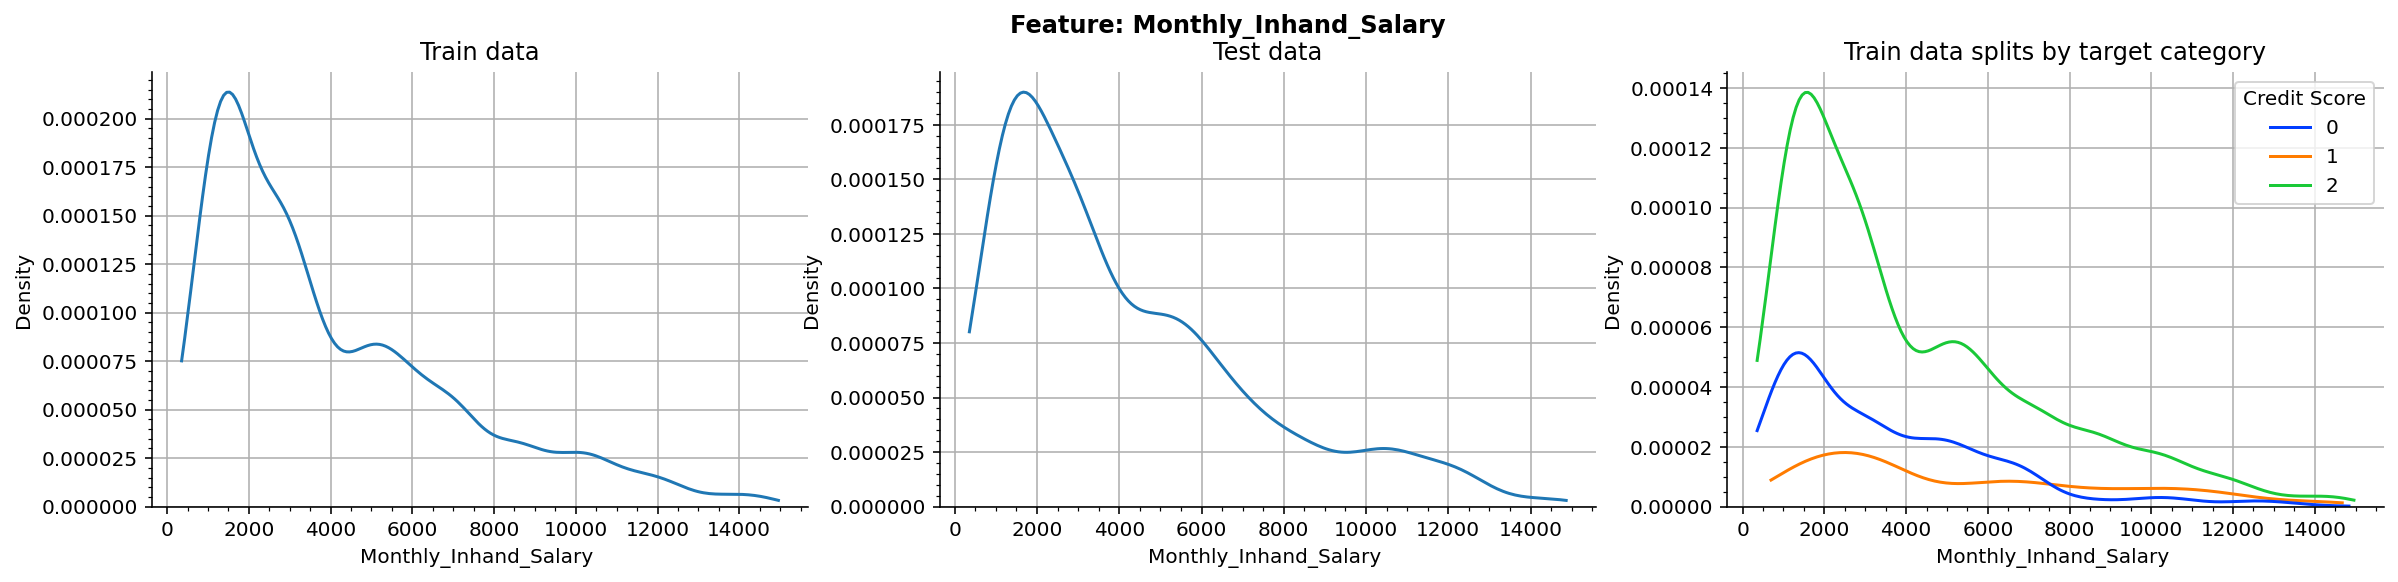


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1373.0,3452.8471,2642.3490,355.2083,1440.0600,2802.8967,4950.0633,14836.7367
1,738.0,5372.7828,3646.2619,695.2596,2417.0350,3758.0200,8044.8975,14672.1000
2,3983.0,4095.4409,3081.3278,355.2083,1643.5325,2980.8300,5830.6683,14958.3367


In [ ]:
explore_cont('Monthly_Inhand_Salary ')

### Accounts of user


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,6094.0,18.1828,121.3760,0.0,4.0,6.0,8.0,1789.0
Test,1524.0,17.6430,118.3912,0.0,3.0,6.0,7.0,1668.0


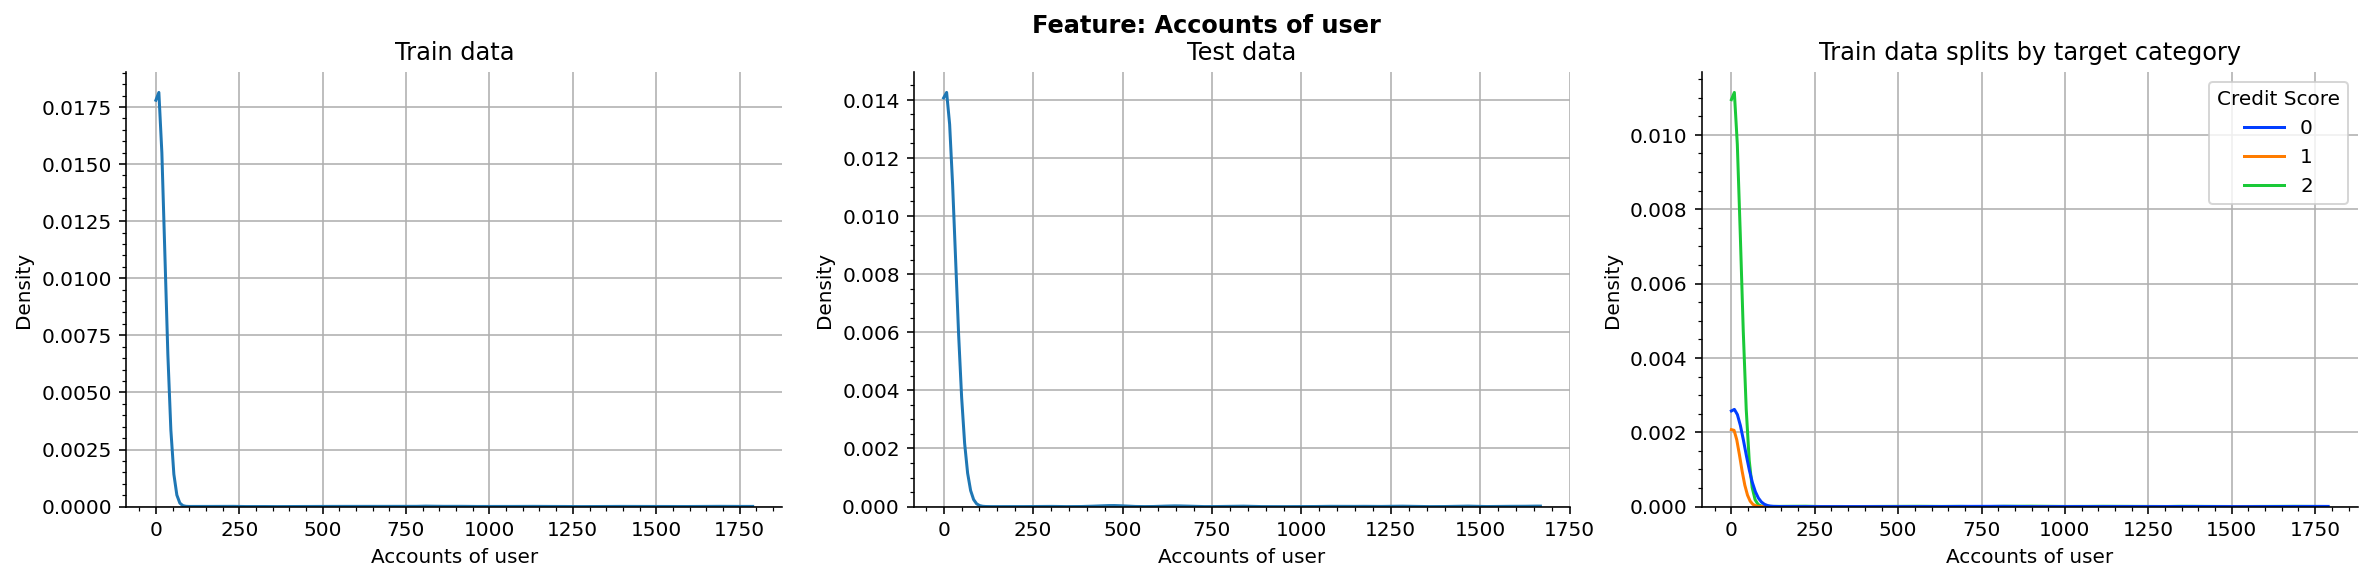


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1373.0,23.1551,142.5478,0.0,5.0,7.0,8.0,1789.0
1,738.0,10.1382,85.4249,0.0,2.0,3.0,5.0,1601.0
2,3983.0,17.9593,119.0368,0.0,4.0,6.0,7.0,1769.0


In [ ]:
explore_cont('Accounts of user')

In [ ]:
len(train.loc[train['Accounts of user'] > 9])

393

In [ ]:
len(train.loc[train['Accounts of user'] > 10])

87

In [ ]:
len(train.loc[train['Accounts of user'] > 20])

87

In [ ]:
#Removing outlier values
train = train[train['Accounts of user'] <= 10]


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,6007.0,5.4523,2.5431,0.0,4.0,6.0,7.0,10.0
Test,1524.0,17.6430,118.3912,0.0,3.0,6.0,7.0,1668.0


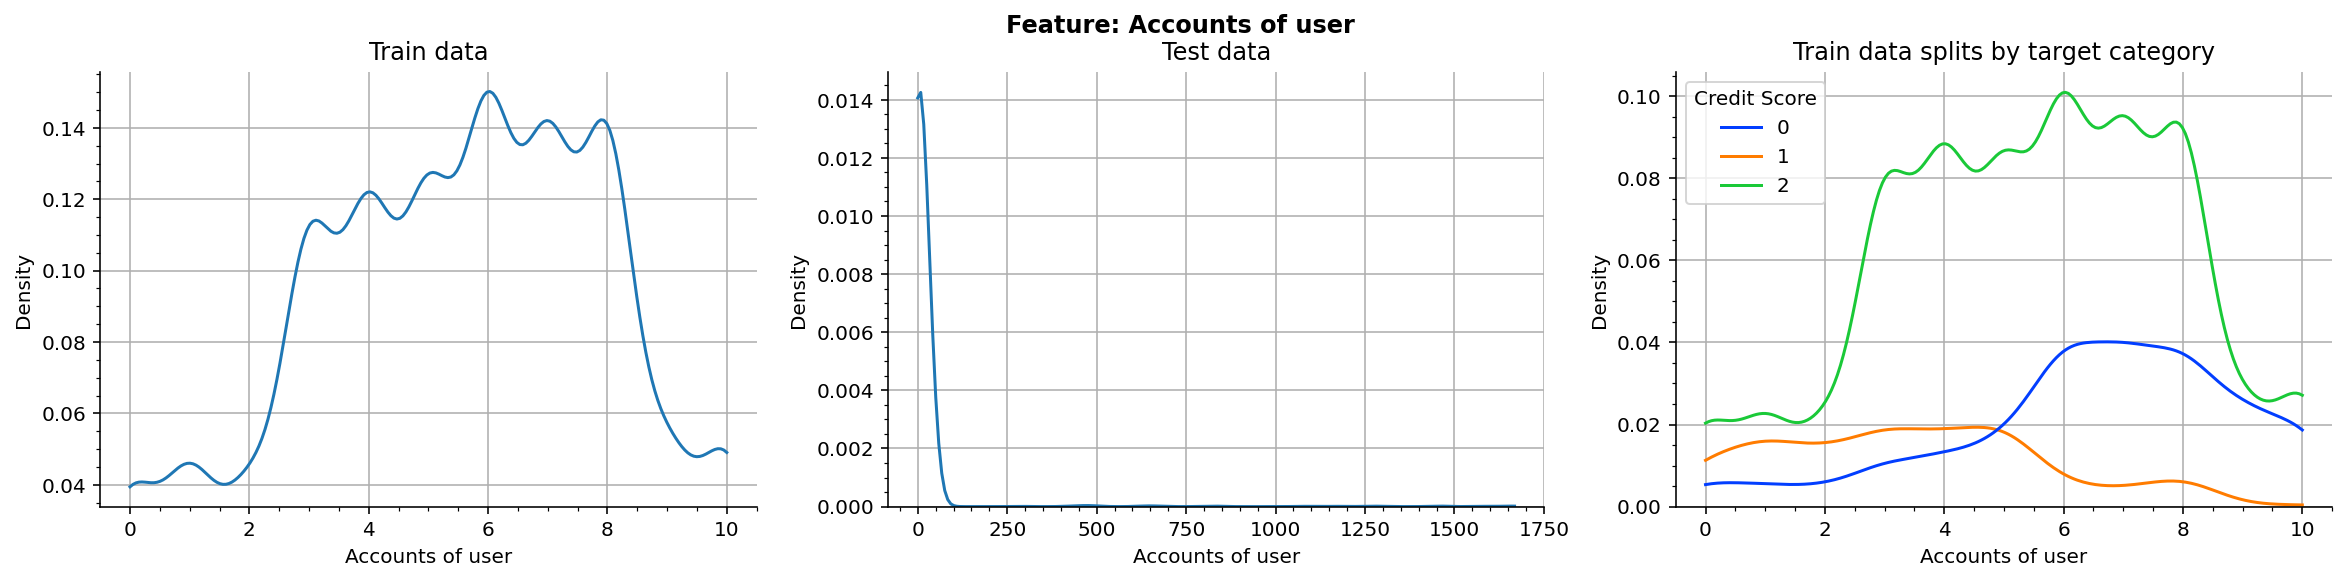


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1349.0,6.5085,2.4256,0.0,5.0,7.0,8.0,10.0
1,733.0,3.4366,2.2761,0.0,2.0,3.0,5.0,10.0
2,3925.0,5.4657,2.4017,0.0,4.0,6.0,7.0,10.0


In [ ]:
explore_cont('Accounts of user')

### Credit cards user have


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,6007.0,21.7473,125.5550,0.0,4.0,6.0,7.0,1484.0
Test,1524.0,24.6588,138.1386,0.0,4.0,5.0,7.0,1480.0


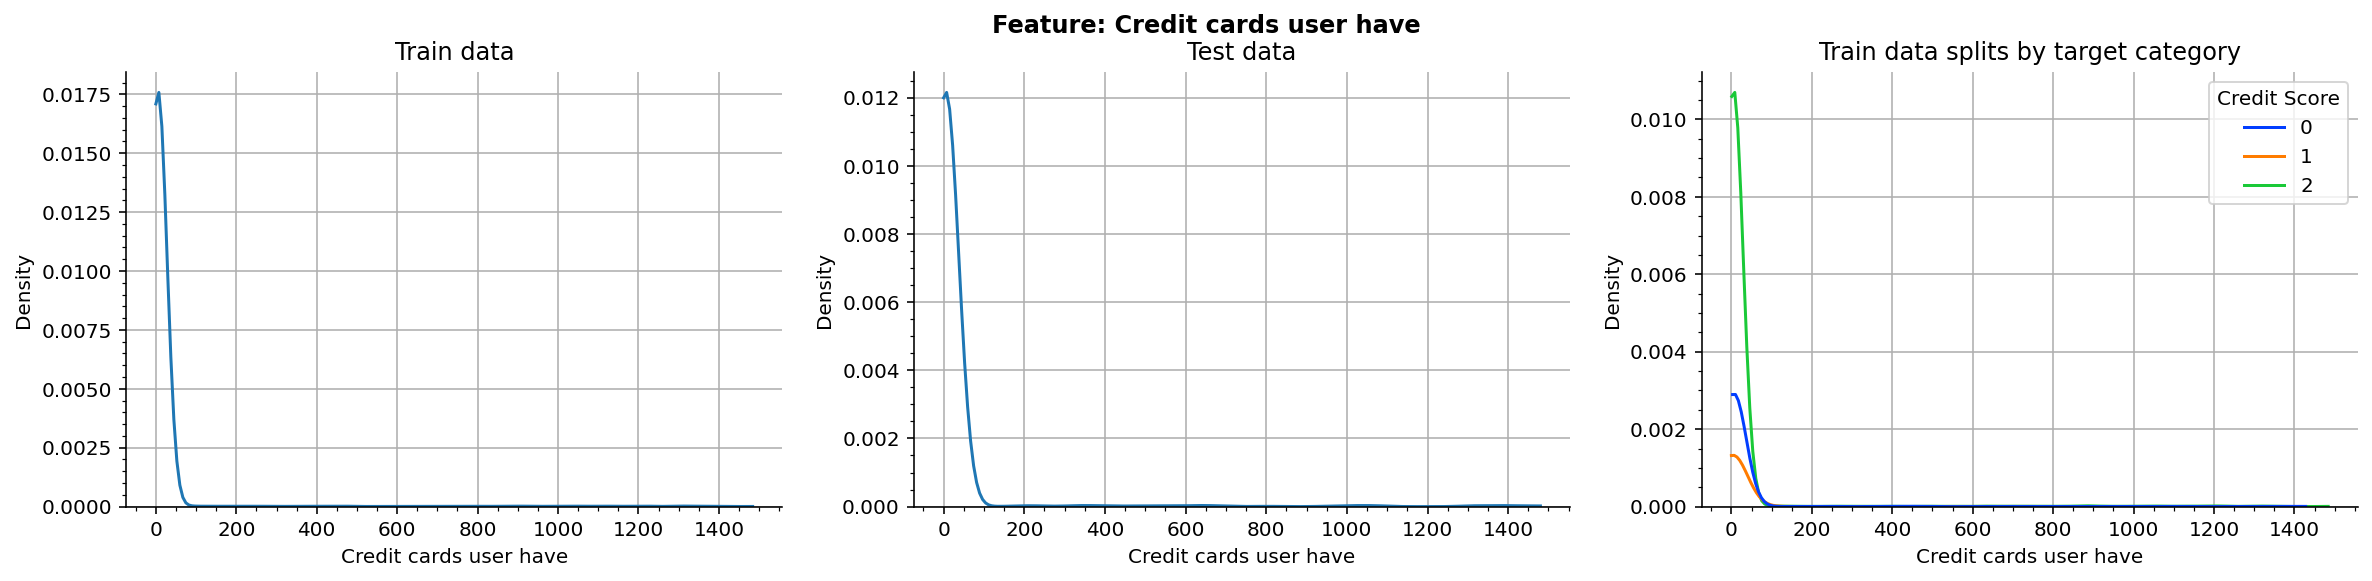


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1349.0,22.4781,127.1492,3.0,5.0,7.0,8.0,1428.0
1,733.0,22.5989,133.5480,0.0,3.0,4.0,6.0,1379.0
2,3925.0,21.3371,123.4782,1.0,4.0,5.0,7.0,1484.0


In [ ]:
explore_cont('Credit cards user have')

In [ ]:
len(train.loc[train['Credit cards user have'] > 9])

412

In [ ]:
len(train.loc[train['Credit cards user have'] > 10])

133

In [ ]:
len(train.loc[train['Credit cards user have'] > 20])

129

In [ ]:
len(train.loc[train['Credit cards user have'] > 50])

127

In [ ]:
#Removing outlier values
train = train[train['Credit cards user have'] <= 10]


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5874.0,5.5686,2.0112,0.0,4.0,5.0,7.0,10.0
Test,1524.0,24.6588,138.1386,0.0,4.0,5.0,7.0,1480.0


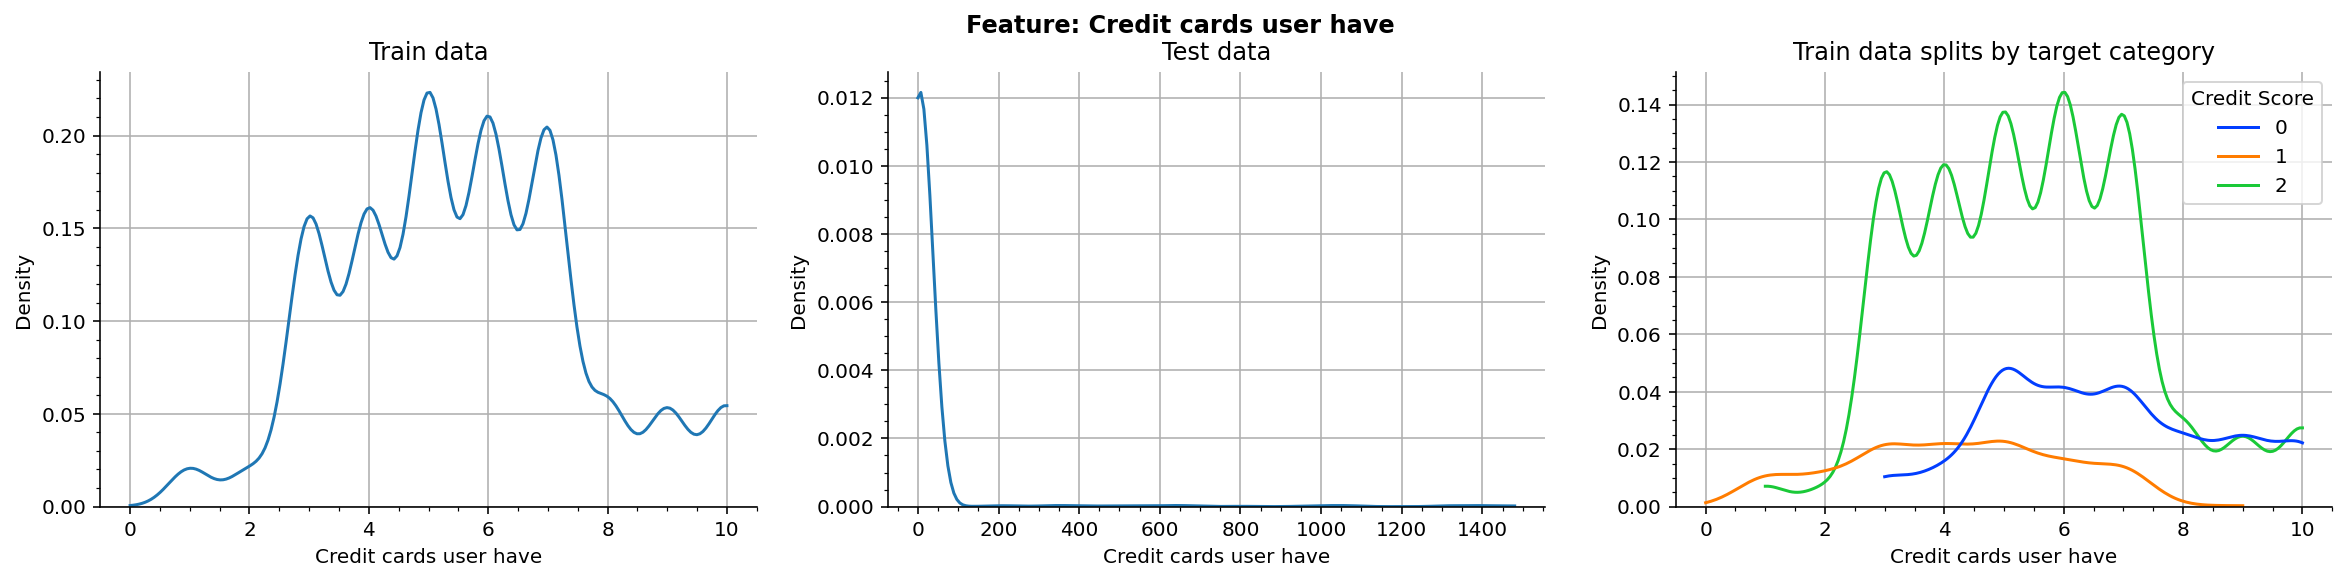


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1323.0,6.6493,1.9156,3.0,5.0,7.0,8.0,10.0
1,714.0,4.1863,1.8317,0.0,3.0,4.0,6.0,9.0
2,3837.0,5.4532,1.8795,1.0,4.0,5.0,7.0,10.0


In [ ]:
explore_cont('Credit cards user have')

### Interest Rate


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5874.0,66.8395,434.3031,1.0,8.0,14.0,20.0,5721.0
Test,1524.0,70.0479,449.6138,1.0,8.0,14.0,21.0,5763.0


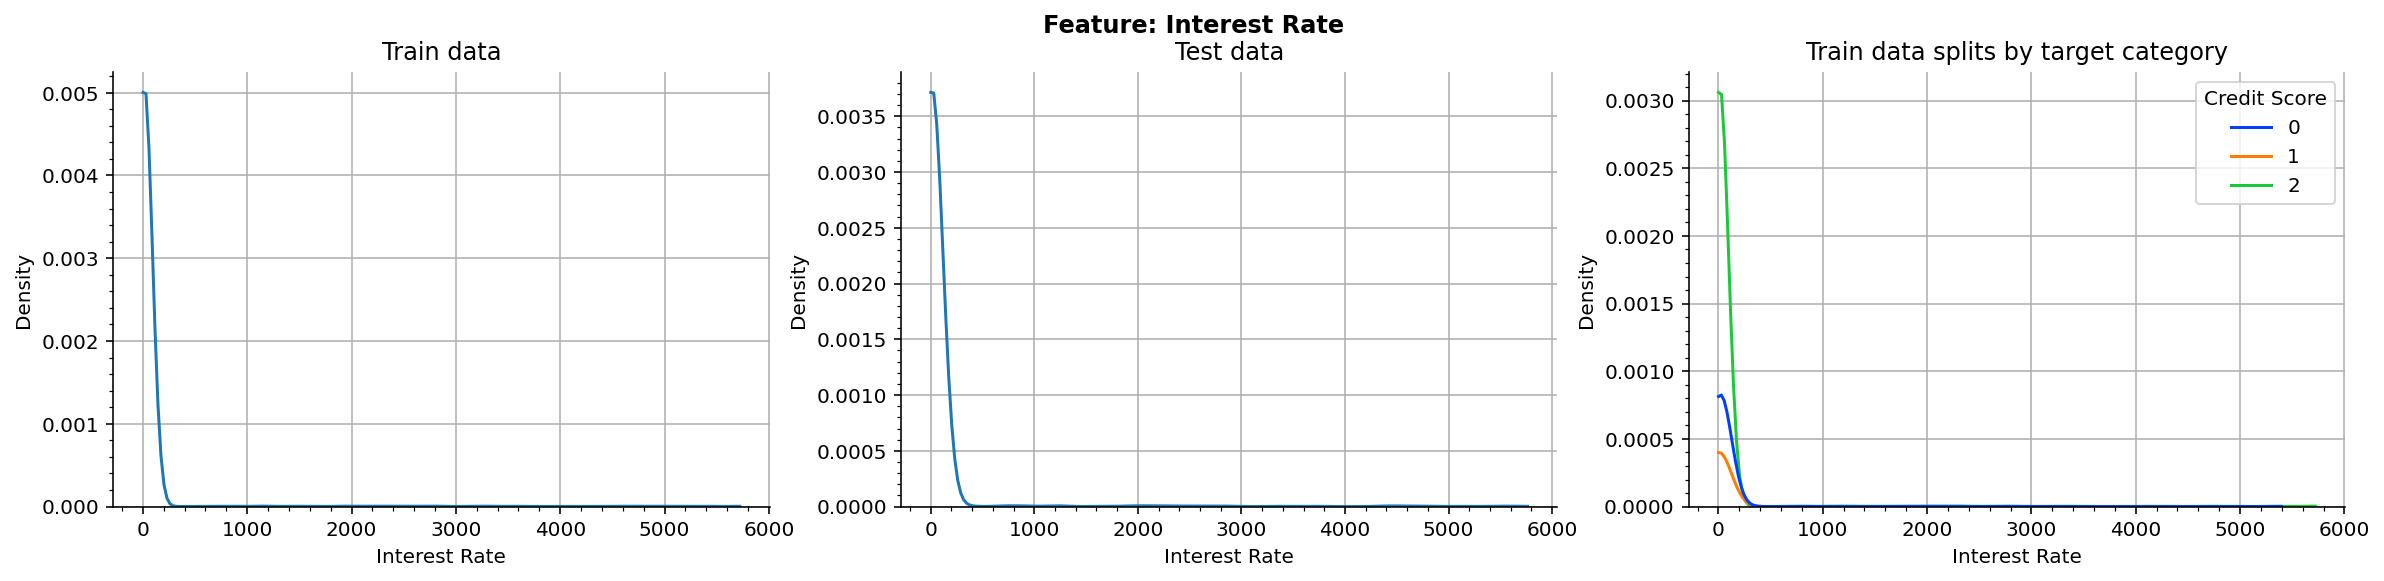


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1323.0,77.6289,446.7378,1.0,15.0,21.0,28.0,5397.0
1,714.0,66.4356,441.1475,1.0,4.0,7.0,11.0,5069.0
2,3837.0,63.1944,428.6896,1.0,8.0,14.0,19.0,5721.0


In [ ]:
explore_cont('Interest Rate')

In [ ]:
len(train.loc[train['Interest Rate'] > 28])

655

In [ ]:
len(train.loc[train['Interest Rate'] > 30])

464

In [ ]:
len(train.loc[train['Interest Rate'] > 35])

107

In [ ]:
len(train.loc[train['Interest Rate'] > 50])

107

In [ ]:
#Removing outlier values
train = train[train['Interest Rate'] <= 35]


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5767.0,14.7706,8.6006,1.0,8.0,14.0,20.0,34.0
Test,1524.0,70.0479,449.6138,1.0,8.0,14.0,21.0,5763.0


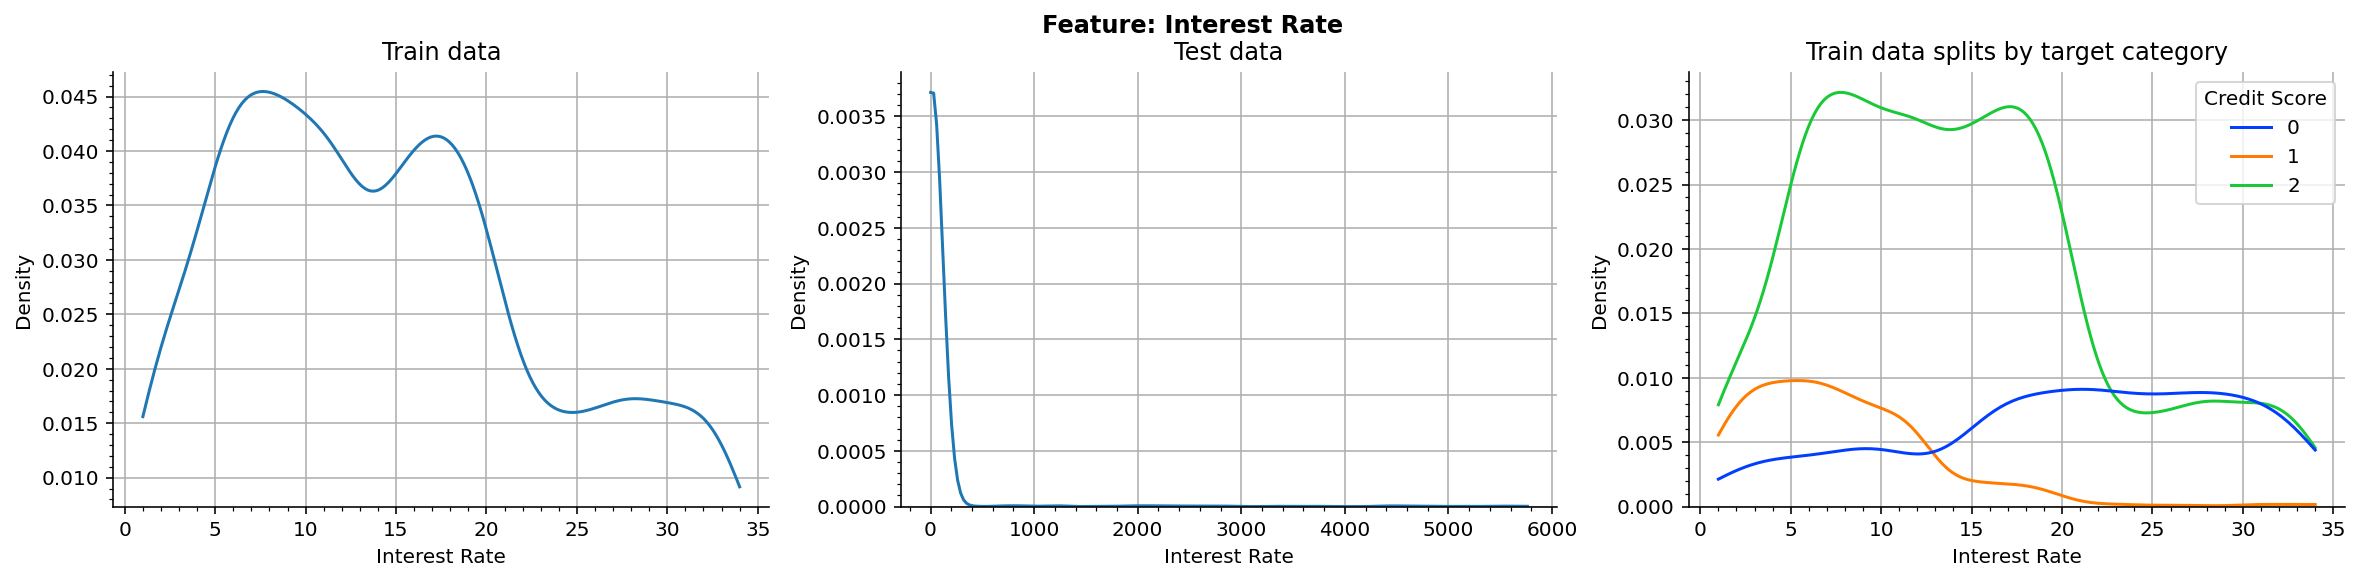


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1296.0,20.2793,8.8884,1.0,15.0,21.0,28.0,34.0
1,699.0,7.7482,5.2200,1.0,4.0,7.0,11.0,34.0
2,3772.0,14.1792,7.8108,1.0,8.0,13.0,19.0,34.0


In [ ]:
explore_cont('Interest Rate')

### Num_of_Loan


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5767.0,2.4550,55.7124,-100.0,2.0,3.0,5.0,1464.0
Test,1524.0,3.5269,57.2336,-100.0,2.0,3.0,5.0,1152.0


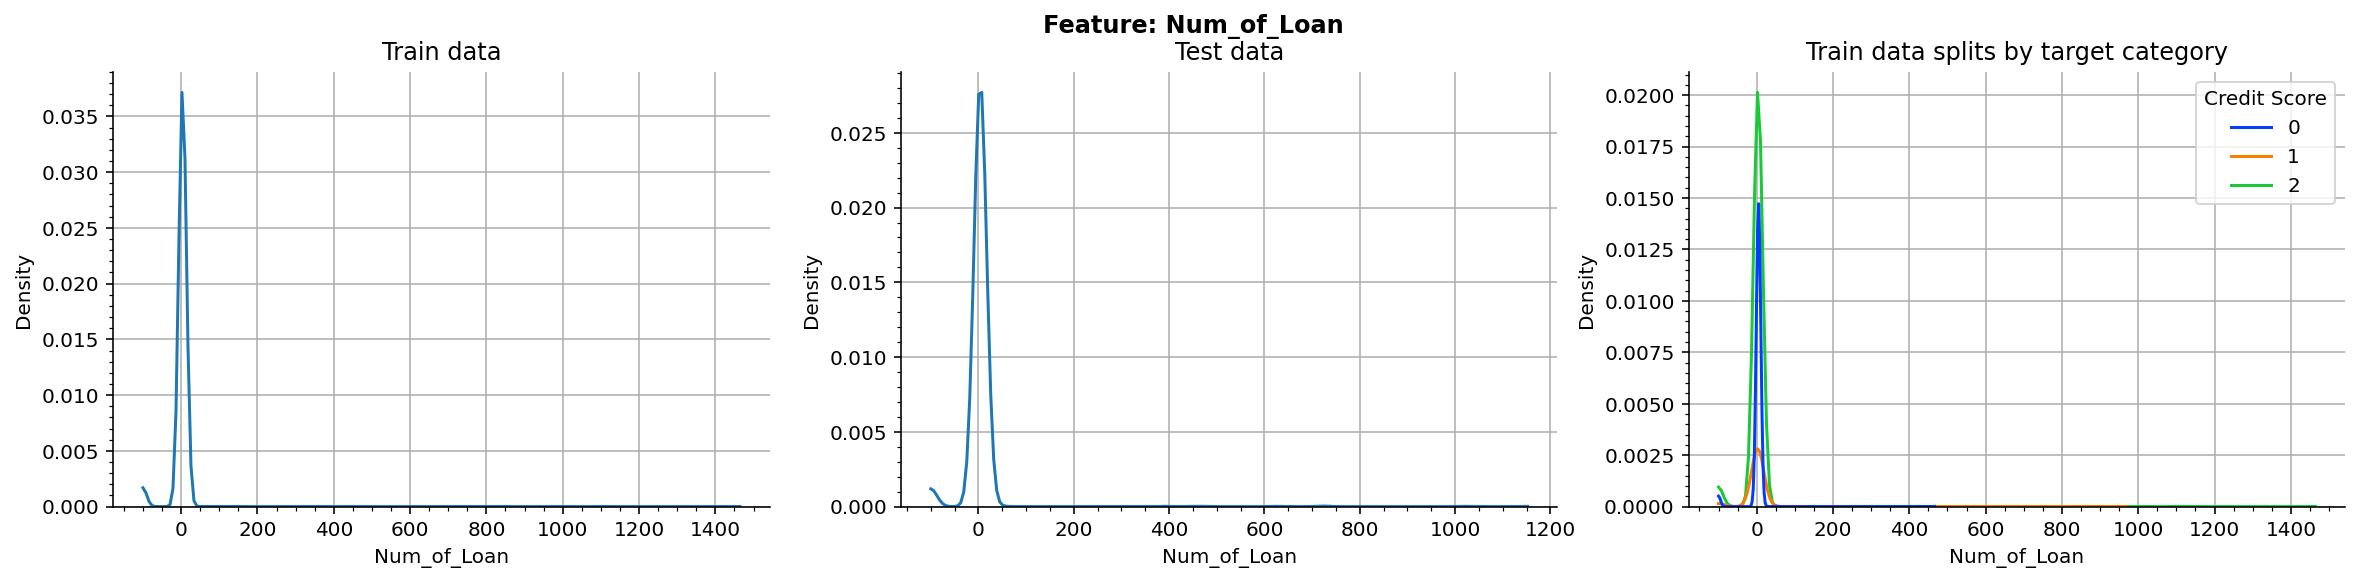


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1296.0,2.1767,22.7694,-100.0,3.0,5.0,7.0,466.0
1,699.0,1.5122,59.9040,-100.0,2.0,2.0,3.0,967.0
2,3772.0,2.7253,62.4773,-100.0,2.0,3.0,5.0,1464.0


In [ ]:
explore_cont('Num_of_Loan')

In [ ]:
len(train.loc[train['Num_of_Loan'] > 7])

446

In [ ]:
len(train.loc[train['Num_of_Loan'] > 8])

258

In [ ]:
len(train.loc[train['Num_of_Loan'] > 10])

26

In [ ]:
len(train.loc[train['Num_of_Loan'] > 20])

26

In [ ]:
#Removing outlier values
train = train[(train['Num_of_Loan'] < 10) & (train['Num_of_Loan'] >= 0)]


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5501.0,3.8880,2.2025,1.0,2.0,3.0,5.0,9.0
Test,1524.0,3.5269,57.2336,-100.0,2.0,3.0,5.0,1152.0


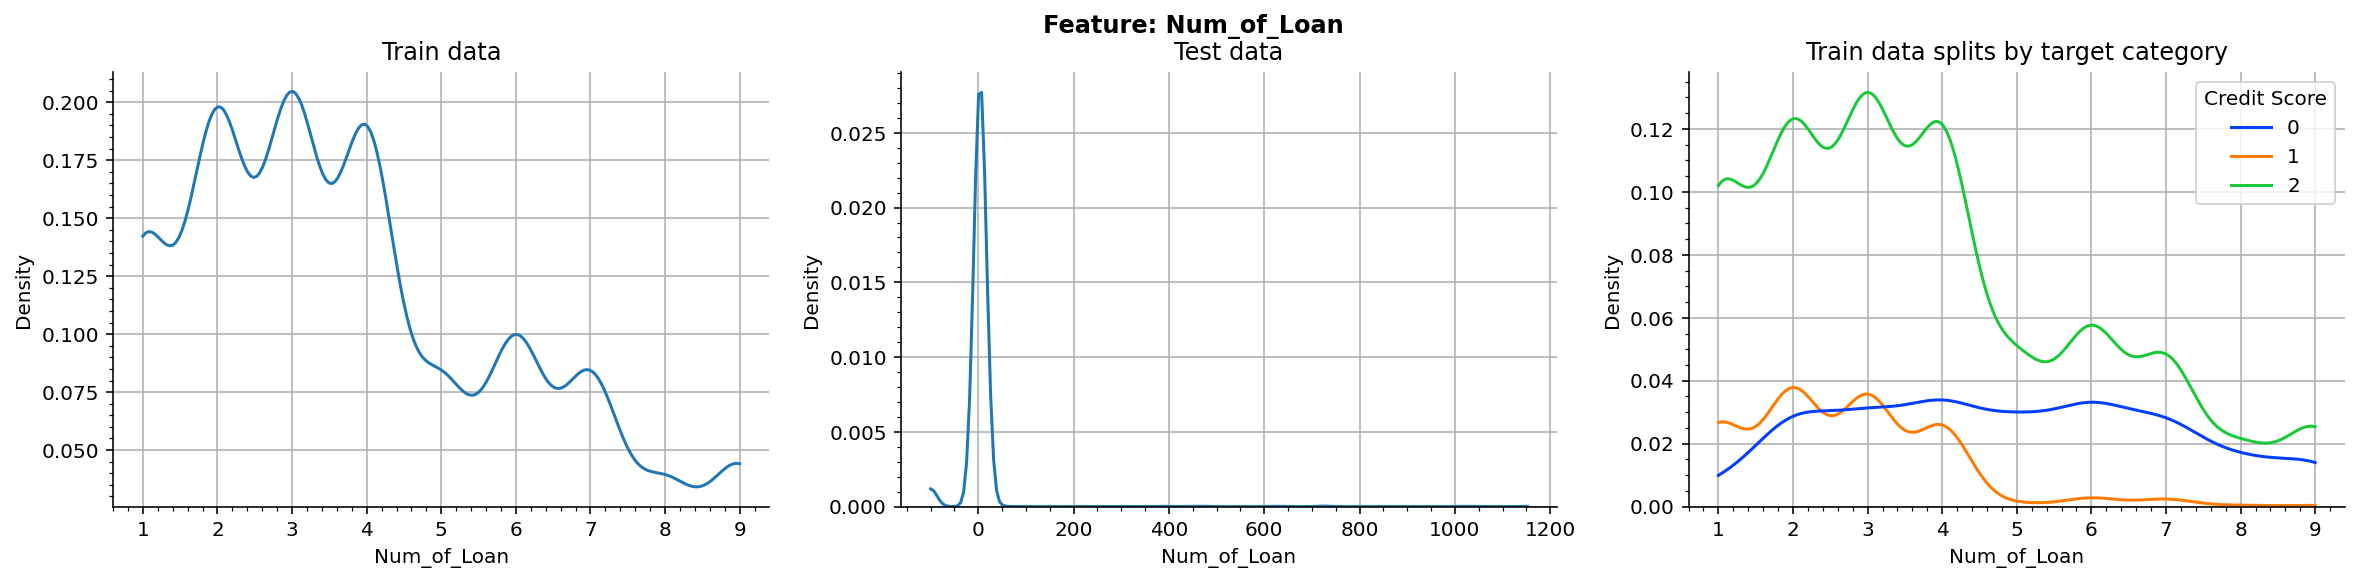


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1253.0,4.9138,2.2071,1.0,3.0,5.0,7.0,9.0
1,660.0,2.6939,1.3751,1.0,2.0,3.0,3.0,9.0
2,3588.0,3.7494,2.1775,1.0,2.0,3.0,5.0,9.0


In [ ]:
explore_cont('Num_of_Loan')

### Delay_from_due_date


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5501.0,21.3792,14.5004,-5.0,10.0,19.0,28.0,66.0
Test,1524.0,21.1207,14.5854,-4.0,10.0,19.0,28.0,67.0


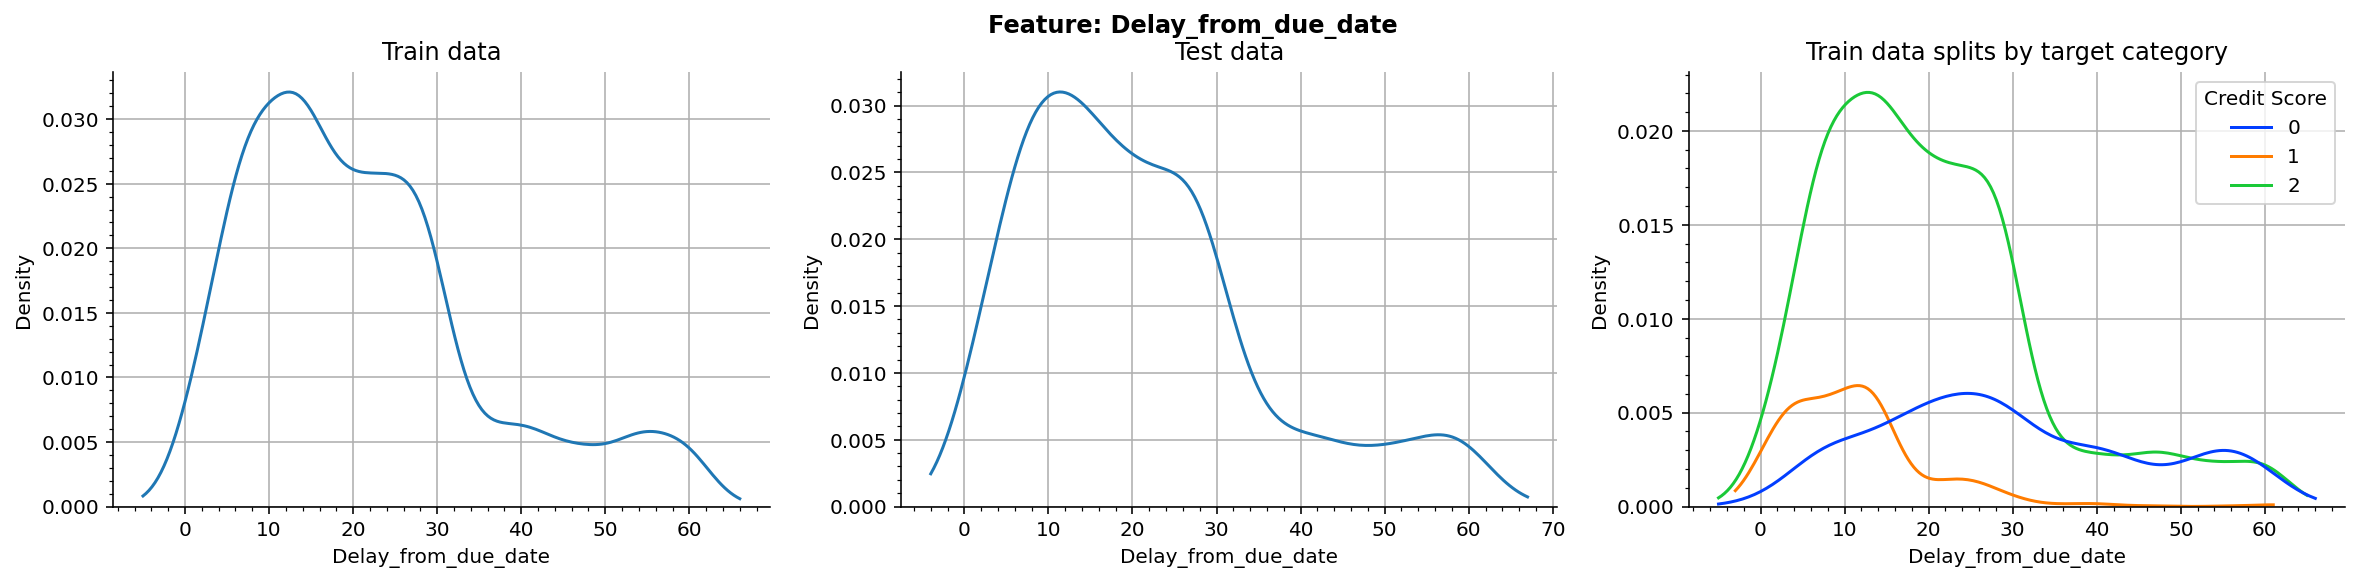


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1253.0,29.6449,15.8551,-5.0,18.0,27.0,41.0,66.0
1,660.0,11.2500,8.7659,-3.0,5.0,10.0,14.0,61.0
2,3588.0,20.3559,13.2945,-5.0,11.0,18.0,27.0,65.0


In [ ]:
explore_cont('Delay_from_due_date')

Negative delay can be acceptable if it represents payment before due date. Thus, we will not treat them as outliers.

### Num_of_Delayed_Payment


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5501.0,28.0362,200.1939,-3.0,9.0,14.0,18.0,4302.0
Test,1524.0,23.3550,173.5753,-2.0,9.0,14.0,18.0,3580.0


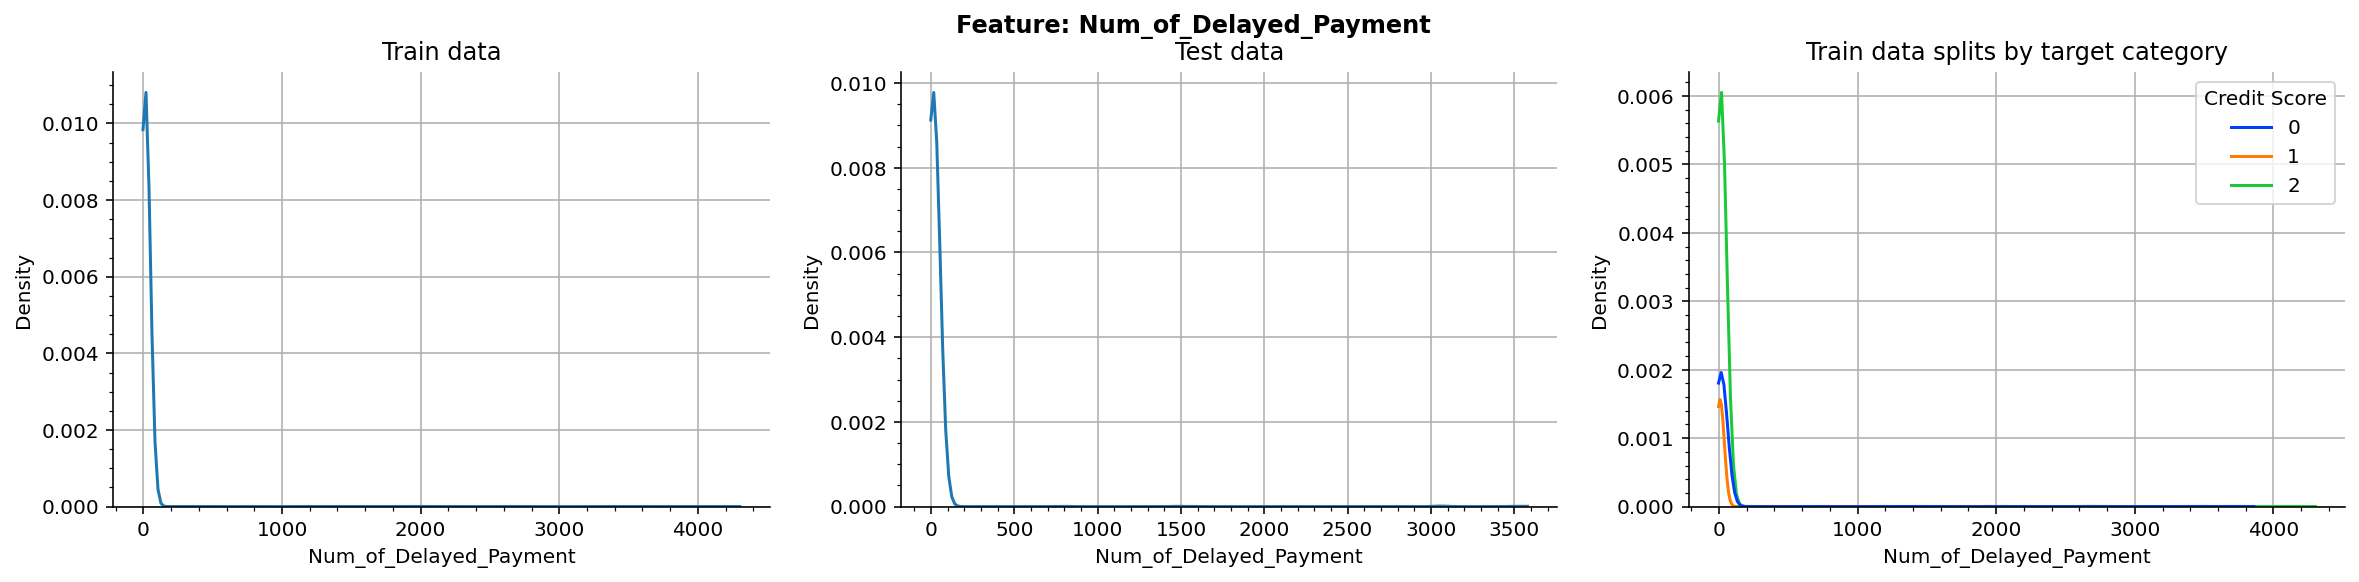


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1253.0,29.4166,190.0797,-3.0,11.0,17.0,20.0,3858.0
1,660.0,14.3121,109.6662,-3.0,4.0,8.0,12.0,2056.0
2,3588.0,30.0786,215.8511,-3.0,10.0,14.0,18.0,4302.0


In [ ]:
explore_cont('Num_of_Delayed_Payment')

In [ ]:
len(train.loc[train['Num_of_Delayed_Payment'] > 20])

706

In [ ]:
len(train.loc[train['Num_of_Delayed_Payment'] > 25])

74

In [ ]:
len(train.loc[train['Num_of_Delayed_Payment'] > 30])

37

In [ ]:
len(train.loc[train['Num_of_Delayed_Payment'] > 40])

37

In [ ]:
#Removing outlier values
train = train[(train['Num_of_Delayed_Payment'] < 30) & (train['Num_of_Delayed_Payment'] >= 0)]


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5432.0,13.6132,6.1529,0.0,9.0,14.0,18.0,28.0
Test,1524.0,23.3550,173.5753,-2.0,9.0,14.0,18.0,3580.0


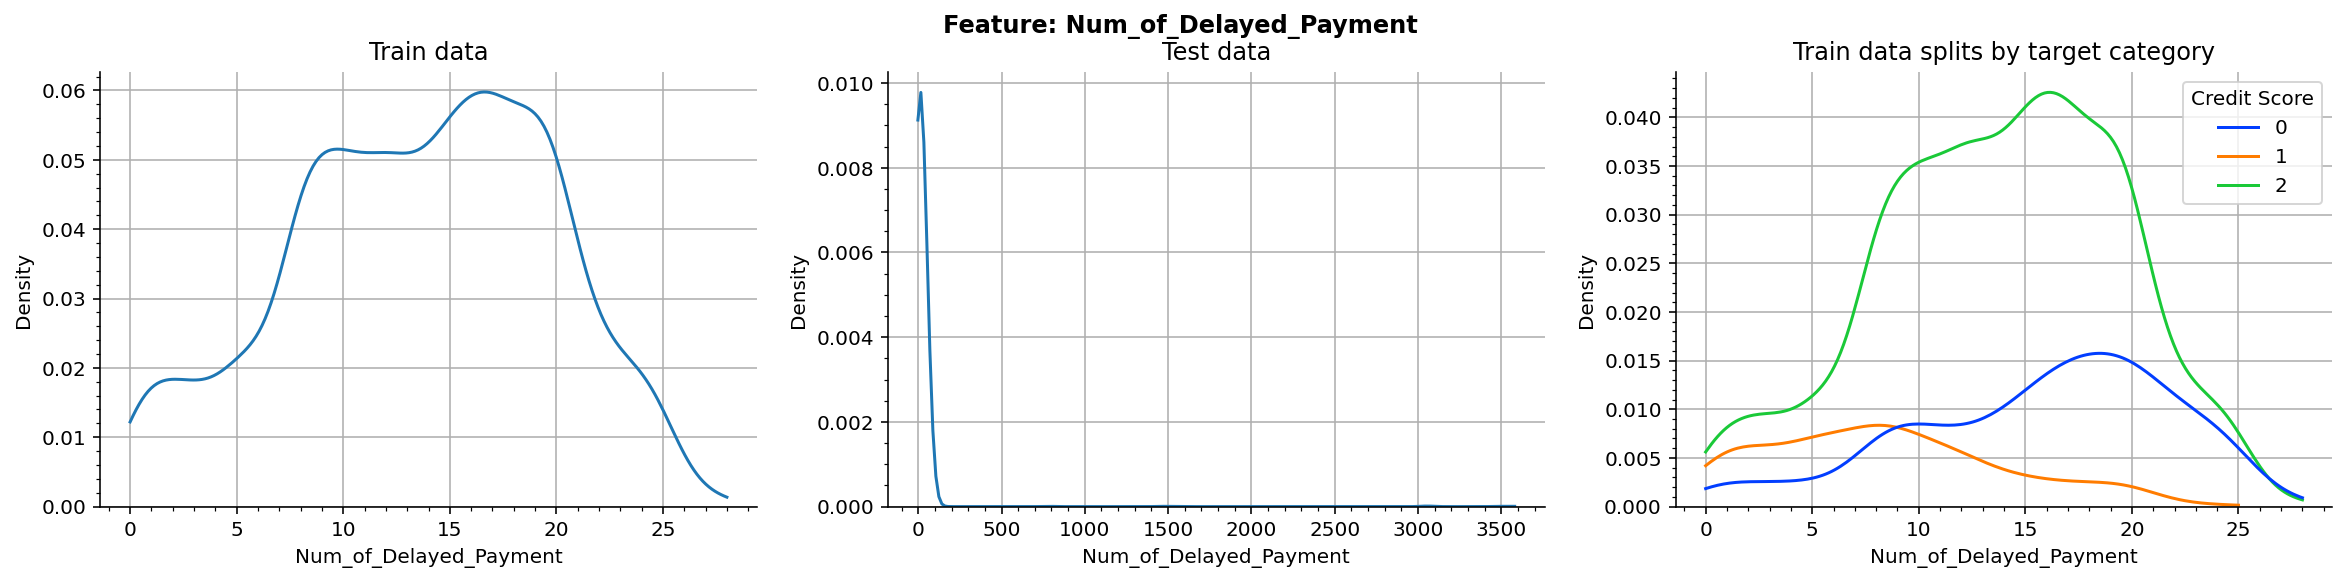


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1239.0,15.7482,6.1559,0.0,11.0,17.0,20.0,28.0
1,647.0,8.4529,5.5472,0.0,4.0,8.0,12.0,25.0
2,3546.0,13.8088,5.7156,0.0,10.0,14.0,18.0,28.0


In [ ]:
explore_cont('Num_of_Delayed_Payment')

### Changed_Credit_Limit


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5432.0,10.8437,6.8992,-6.48,5.7475,9.83,15.55,35.84
Test,1524.0,10.8259,6.8354,-5.63,6.0375,9.72,15.28,34.02


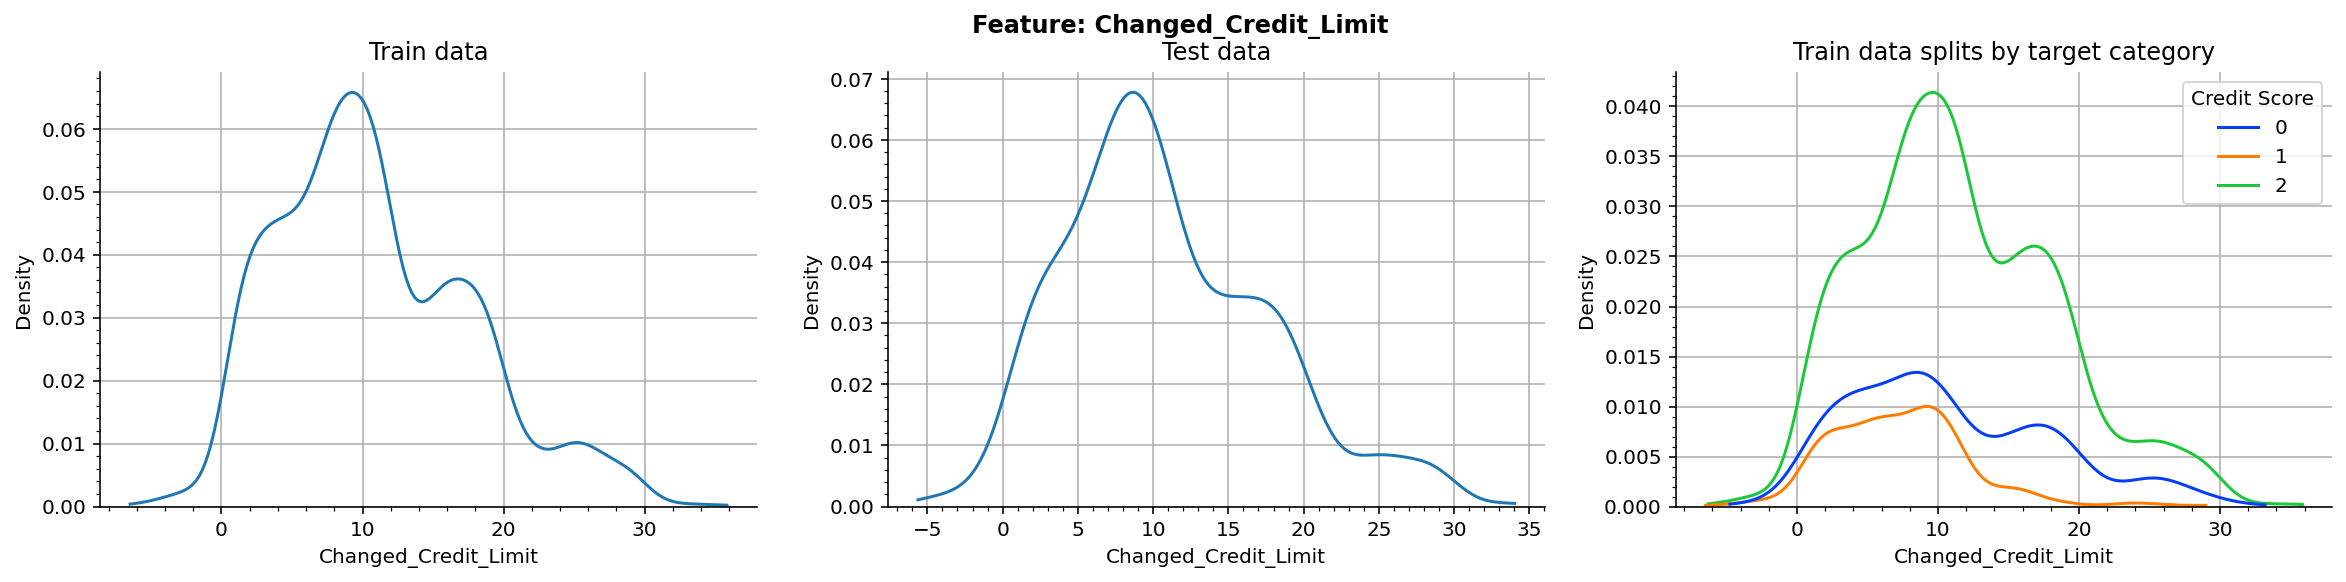


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1239.0,10.8441,7.2348,-4.77,5.120,9.550,16.29,33.19
1,647.0,7.2851,4.8909,-6.48,3.695,7.030,10.06,28.98
2,3546.0,11.4928,6.8957,-6.31,6.690,10.605,16.25,35.84


In [ ]:
explore_cont('Changed_Credit_Limit')

In [ ]:
#Removing outlier values
train = train[train['Changed_Credit_Limit'] >= 0]

### Outstanding_Debt


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5363.0,1444.3598,1188.1551,0.95,554.875,1161.10,1941.95,4998.07
Test,1524.0,1436.6218,1155.0142,1.48,573.610,1175.97,2042.27,4983.86


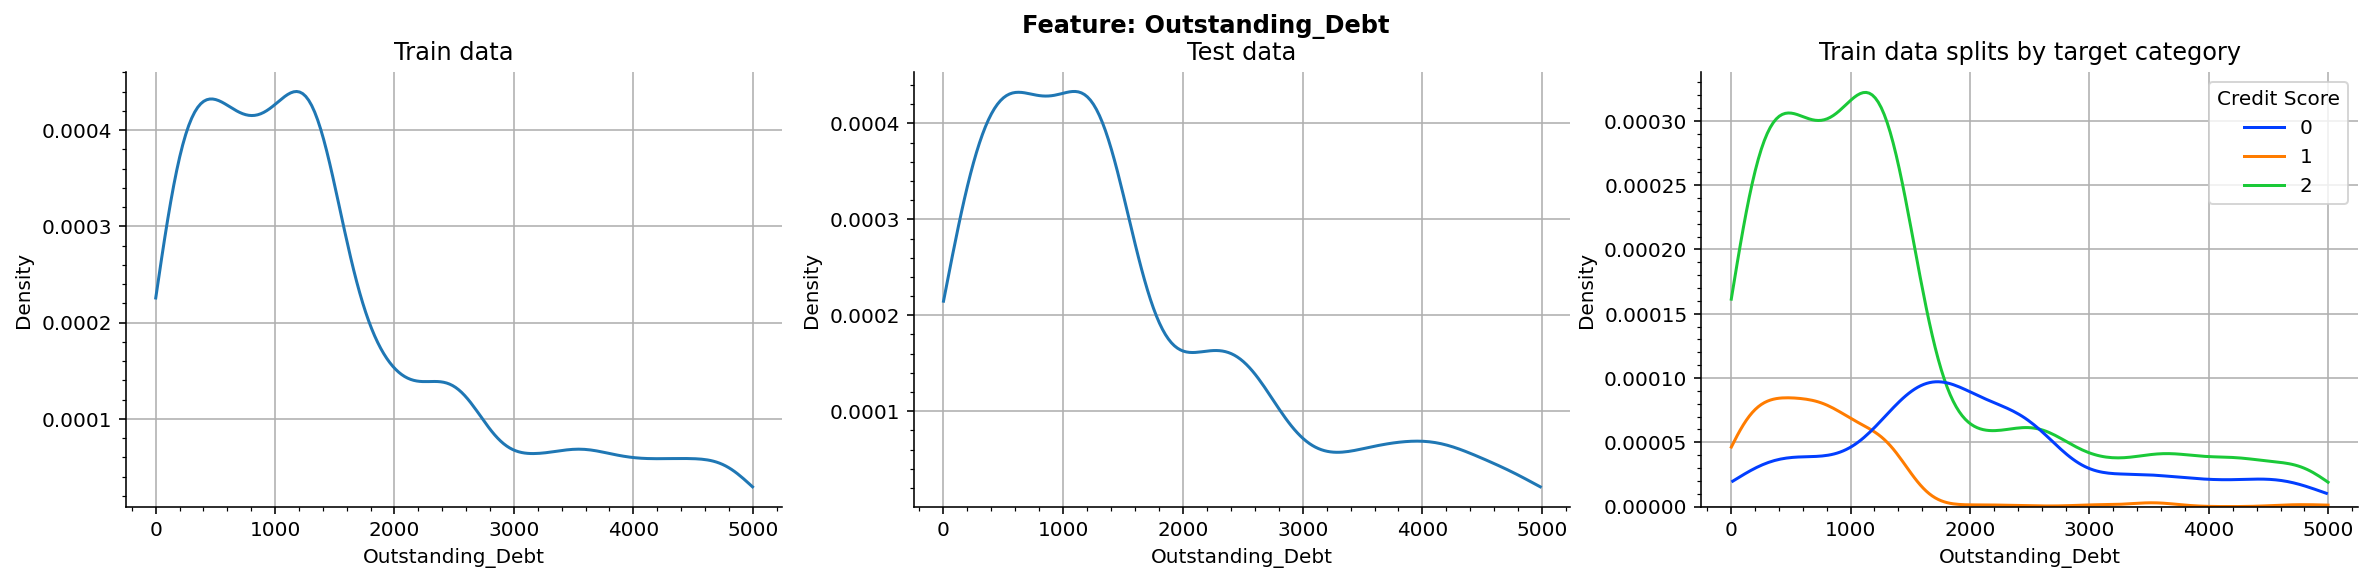


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1224.0,2081.6052,1161.5142,13.24,1356.785,1916.480,2593.2825,4983.86
1,630.0,765.3679,667.8364,1.48,326.260,670.755,1039.4900,4998.07
2,3509.0,1343.9827,1171.7222,0.95,506.300,1057.790,1552.1700,4998.07


In [ ]:
explore_cont('Outstanding_Debt')

### Total_EMI_per_month


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5363.0,1614.5614,8904.1499,4.4628,39.8722,77.3570,173.7082,82204.0
Test,1524.0,1792.6573,9472.2062,5.9135,42.6310,80.2185,182.9322,81186.0


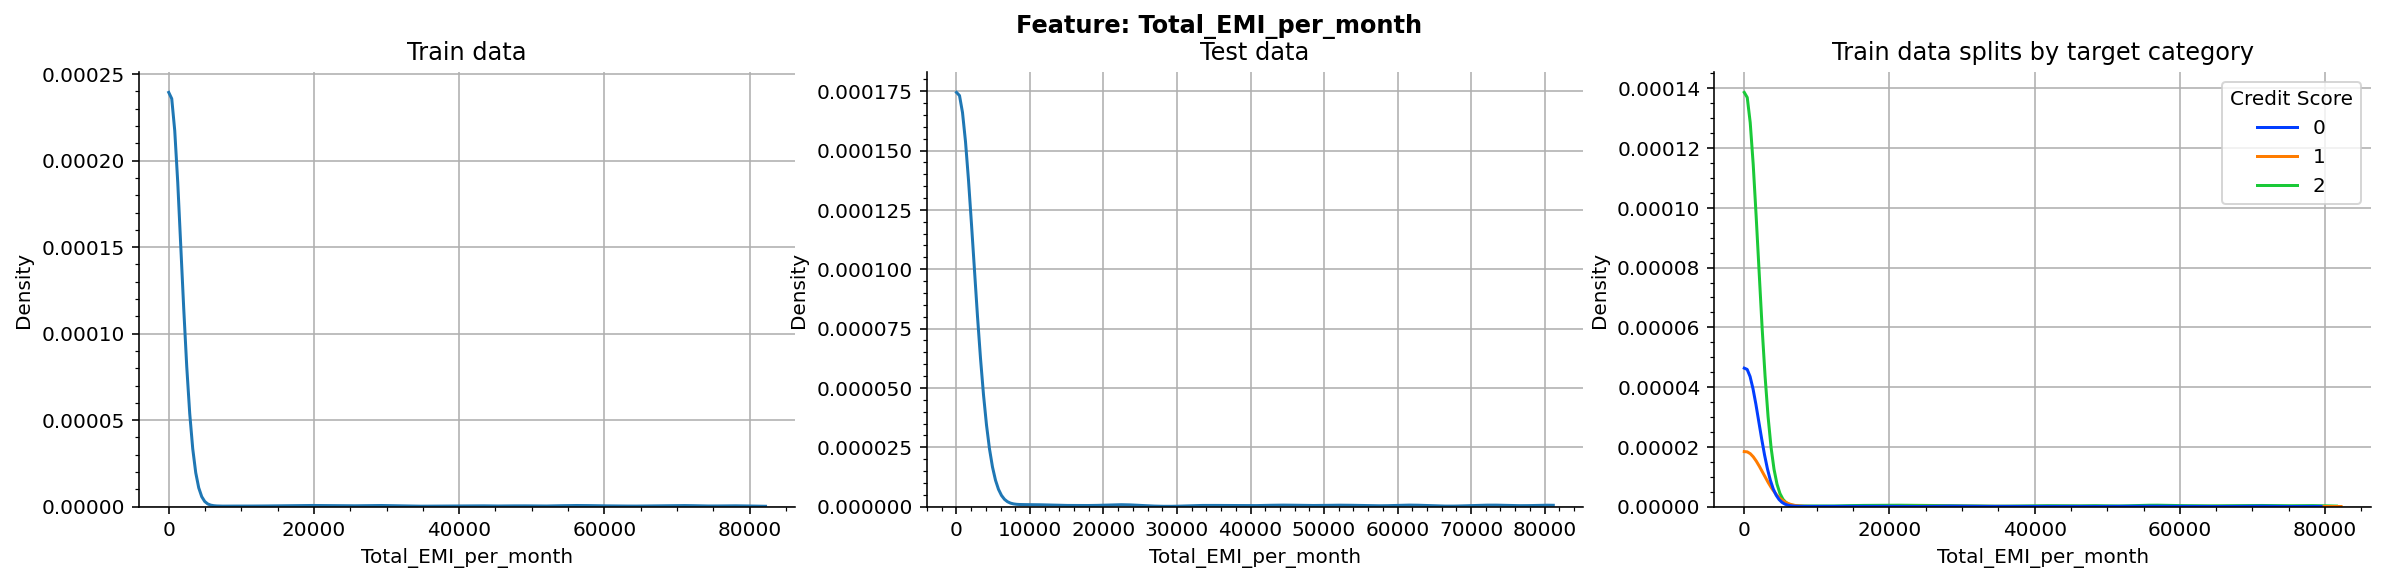


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1224.0,1337.9145,7869.2712,5.7114,44.0010,89.2306,192.1659,79448.0
1,630.0,1636.7034,8891.8373,7.8678,38.4593,74.3792,180.3406,82204.0
2,3509.0,1707.0854,9240.3858,4.4628,38.9332,74.5575,167.0815,81578.0


In [ ]:
explore_cont('Total_EMI_per_month')

In [ ]:
len(train.loc[train['Total_EMI_per_month'] > 200])

1119

In [ ]:
len(train.loc[train['Total_EMI_per_month'] > 500])

254

In [ ]:
len(train.loc[train['Total_EMI_per_month'] > 1000])

205

In [ ]:
len(train.loc[train['Total_EMI_per_month'] > 5000])

184

In [ ]:
#Removing outlier values
train = train[train['Total_EMI_per_month'] < 1000]

### Amount_invested_monthly


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5158.0,181.9468,175.8725,0.0,69.0801,124.2870,222.1824,1607.3035
Test,1524.0,186.9614,177.3433,0.0,70.5522,129.4871,236.6242,1241.0965


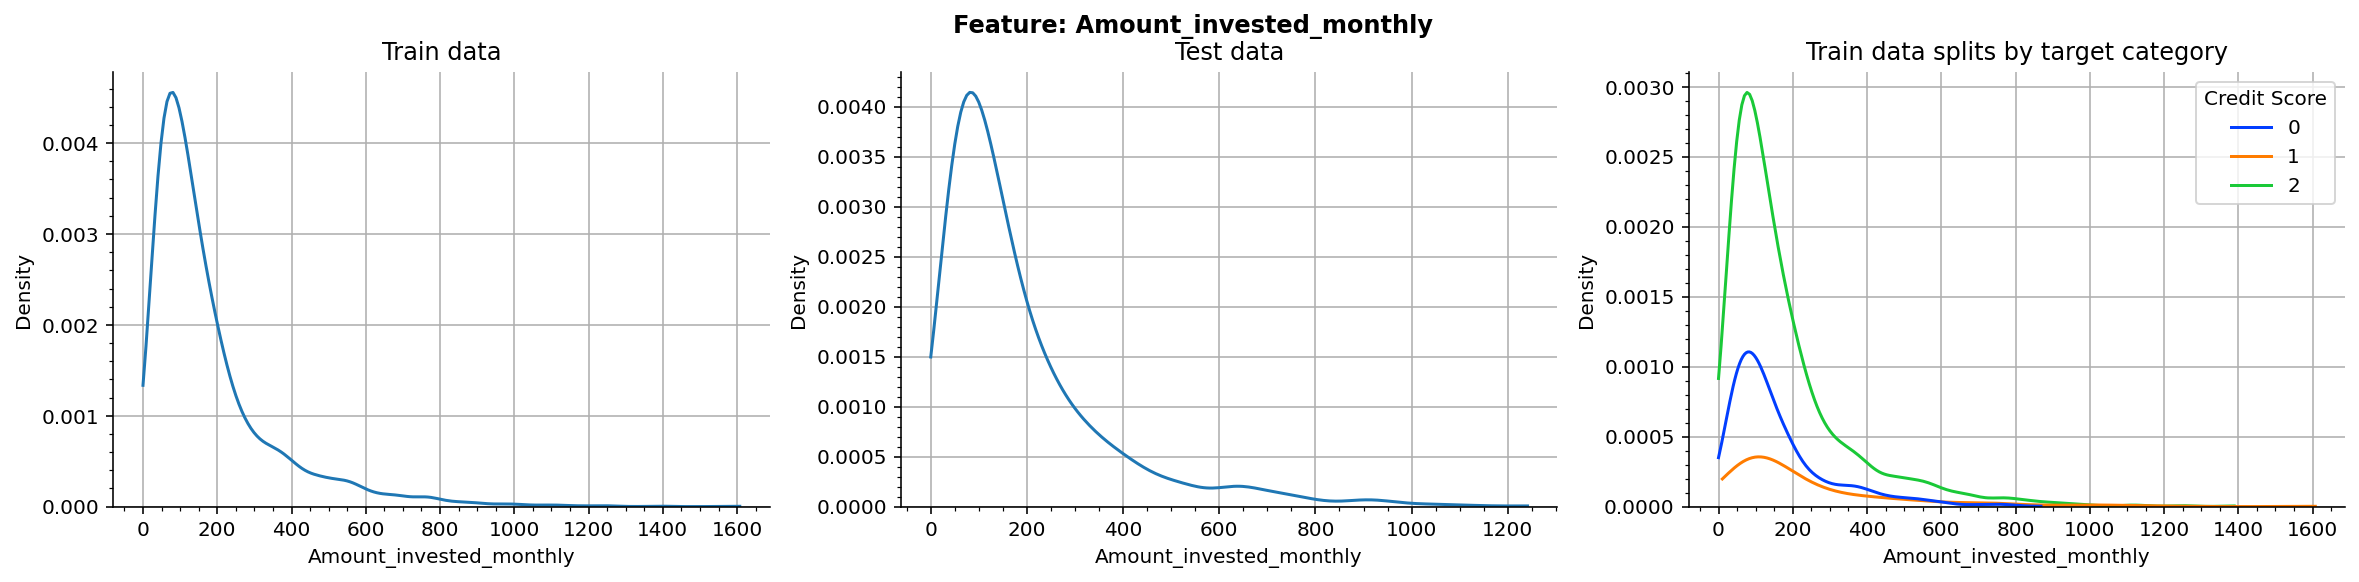


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1186.0,159.6003,138.8761,0.0000,67.0894,116.2401,196.2766,868.4216
1,600.0,234.9636,236.6810,10.2963,83.6295,147.6990,293.4816,1607.3035
2,3372.0,180.3730,172.9355,0.0000,68.1547,123.1368,221.4058,1388.9504


In [ ]:
explore_cont('Amount_invested_monthly')

### Monthly_Balance


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5158.0,385.9341,197.1317,0.6883,268.0503,331.2413,446.3599,1435.3436
Test,1524.0,384.9920,191.2191,2.6286,268.4131,330.2408,447.3408,1510.1067


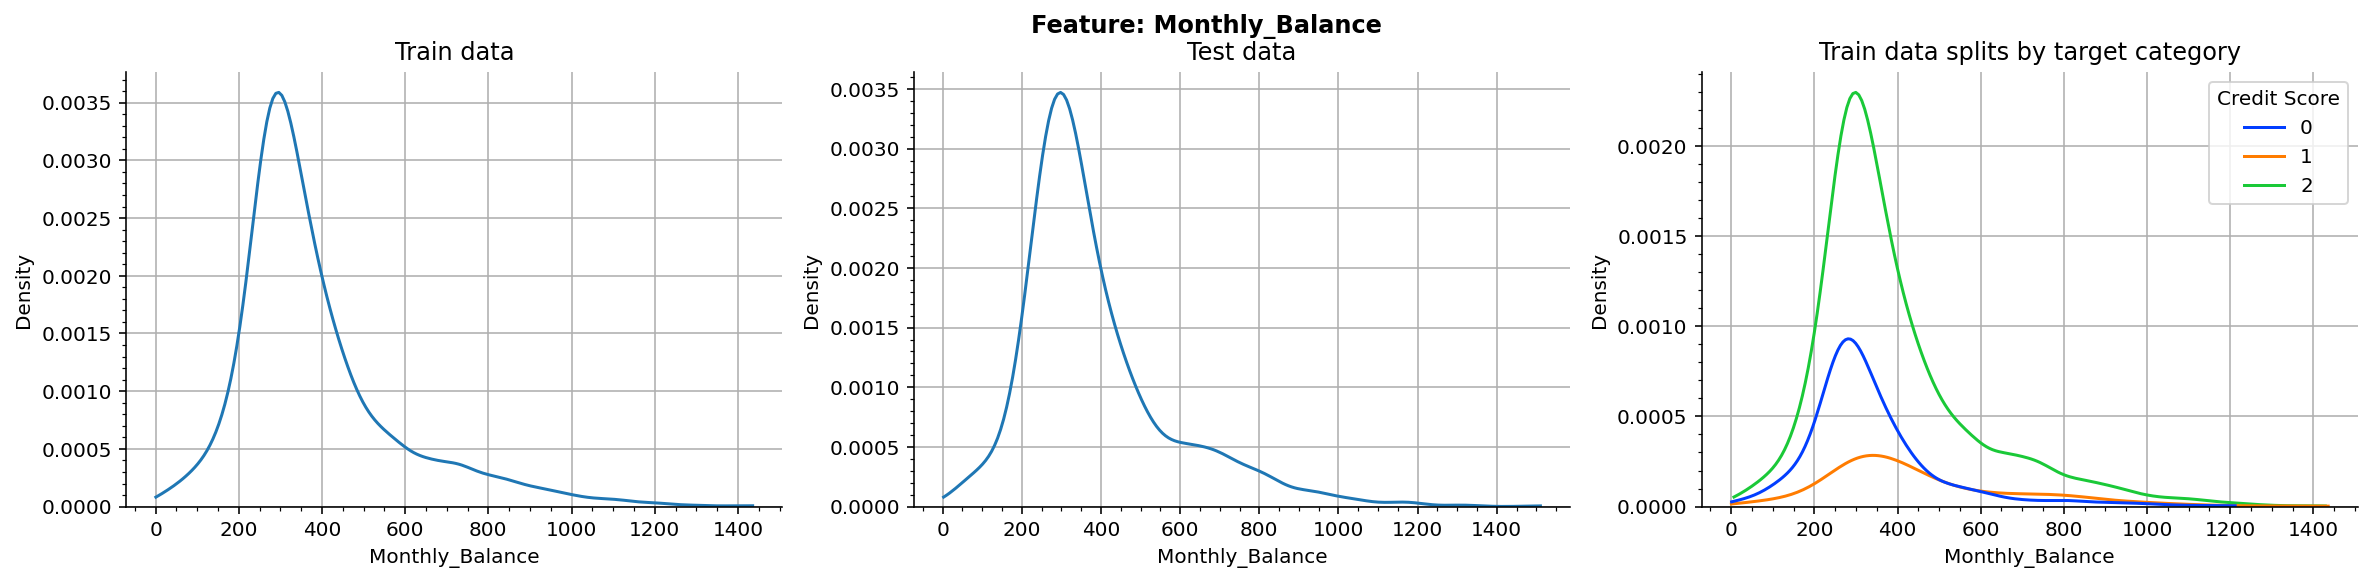


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1186.0,337.4238,164.8452,1.2276,250.3406,299.8845,384.3356,1211.6953
1,600.0,453.9446,233.3164,0.6883,300.1576,389.9154,556.4865,1435.3436
2,3372.0,390.8947,196.3384,6.8300,271.9340,334.2862,454.0138,1428.4615


In [ ]:
explore_cont('Monthly_Balance')

### Utlization Ratio


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5158.0,81.1537,8.7538,70.0,74.0,78.0,88.0,99.0
Test,1524.0,81.0636,8.6057,70.0,74.0,78.0,88.0,99.0


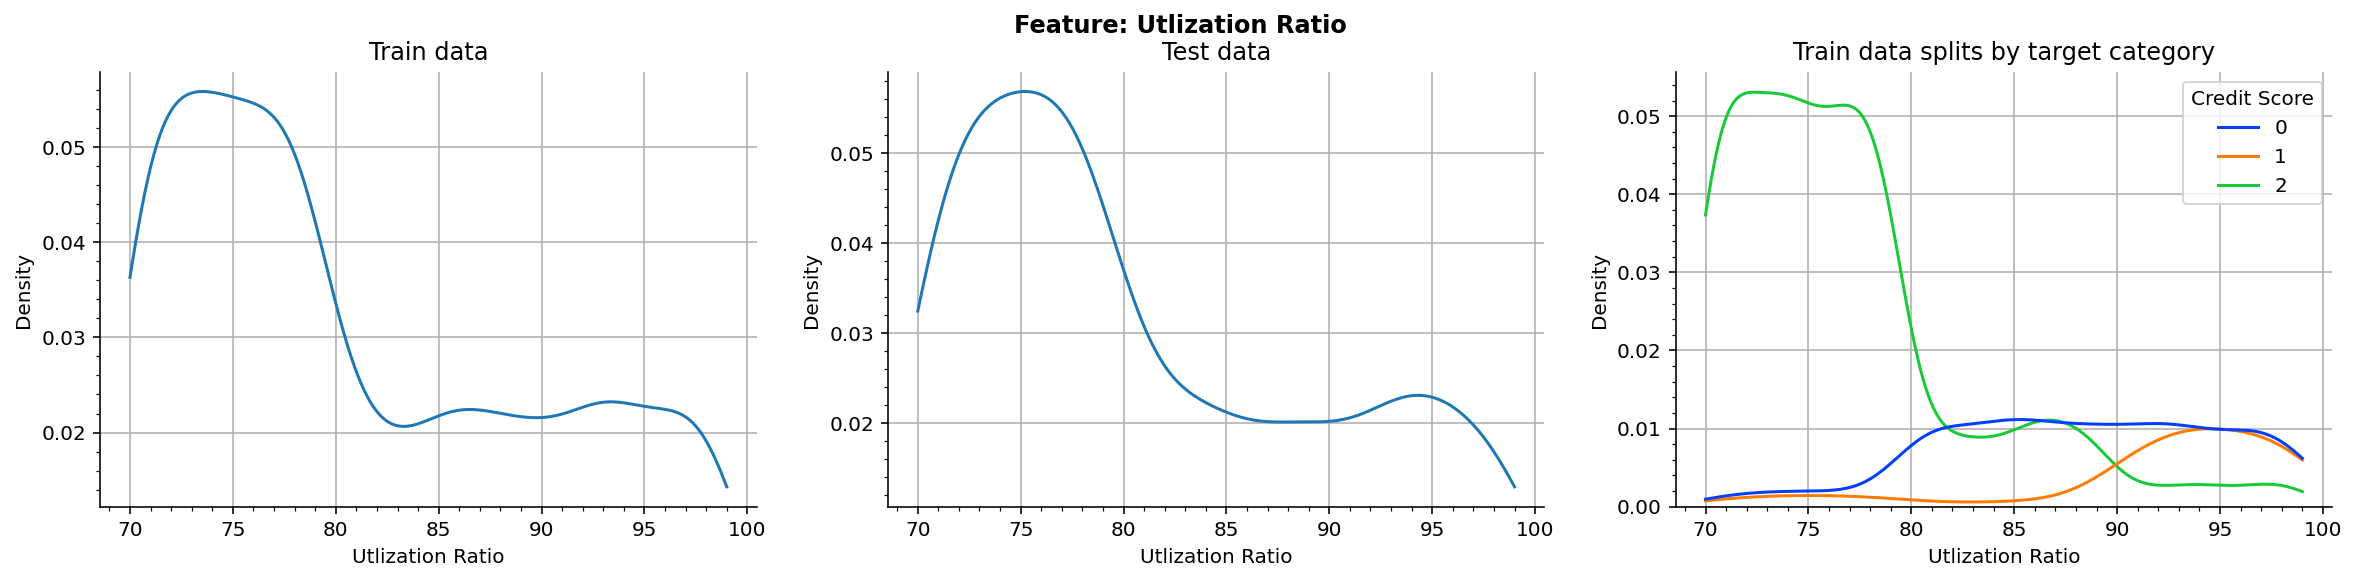


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1186.0,88.1121,6.8206,70.0,83.0,88.0,94.0,99.0
1,600.0,91.8000,7.1807,70.0,91.0,94.0,97.0,99.0
2,3372.0,76.8120,5.9705,70.0,72.0,76.0,79.0,99.0


In [ ]:
explore_cont('Utlization Ratio')

### Credit Inquiries


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5158.0,13.1041,5.1110,0.0,10.0,15.0,17.0,19.0
Test,1524.0,12.9304,5.2774,0.0,9.0,15.0,17.0,19.0


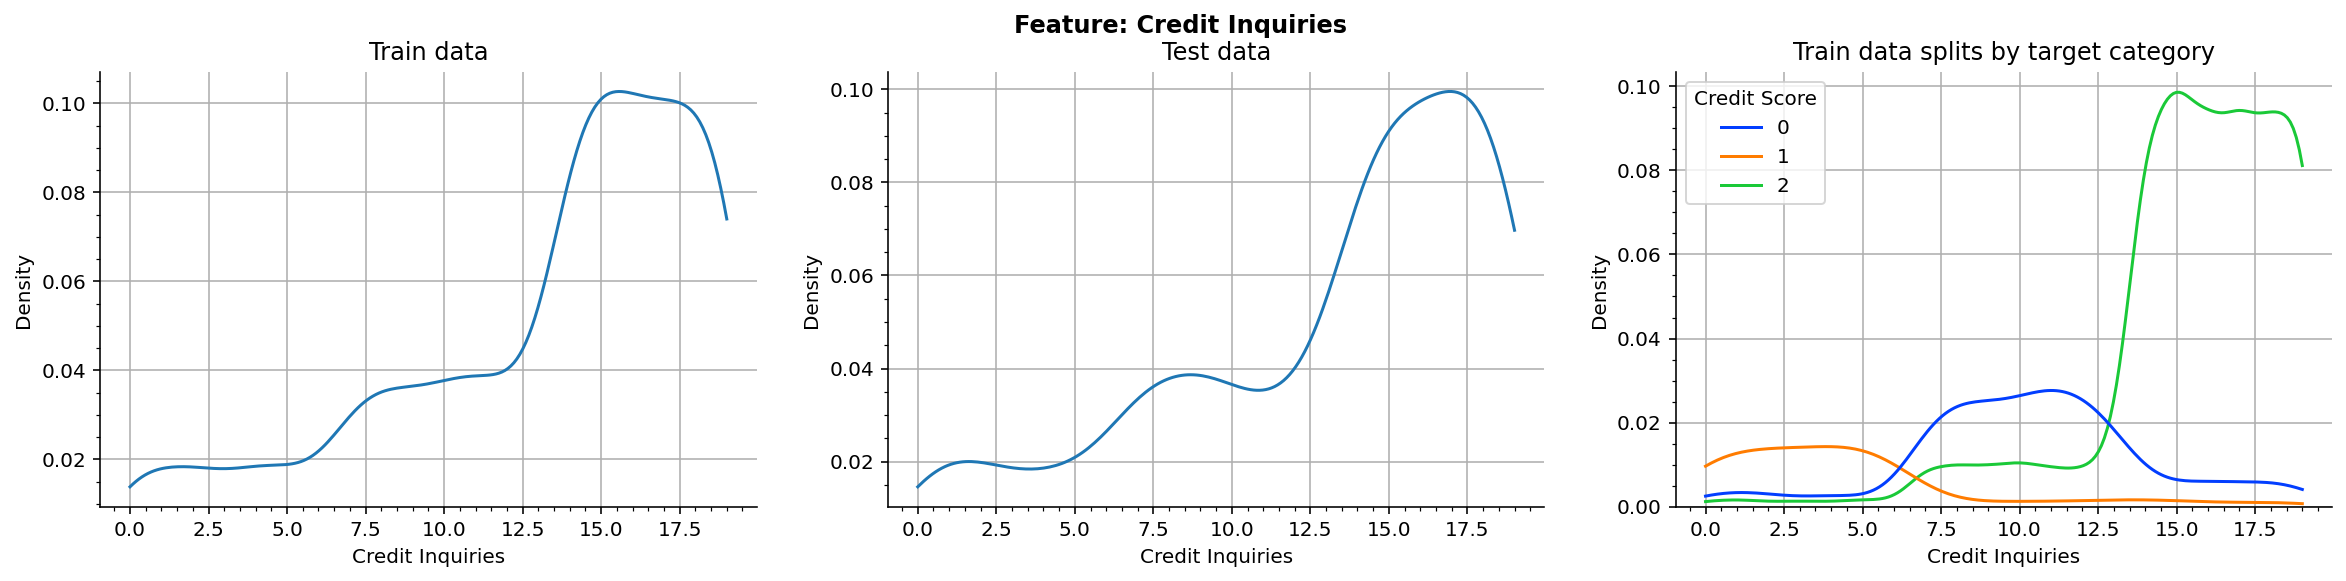


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1186.0,10.3836,3.7990,0.0,8.0,10.0,12.0,19.0
1,600.0,4.3983,4.1216,0.0,2.0,4.0,6.0,19.0
2,3372.0,15.6100,3.0813,0.0,14.0,16.0,18.0,19.0


In [ ]:
explore_cont('Credit Inquiries')

### Cumulative Balance


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5158.0,2988.4775,1145.250,1000.0,1994.50,2978.0,3971.0,4999.0
Test,1524.0,2994.5545,1180.301,1003.0,1939.75,2995.5,4031.0,4997.0


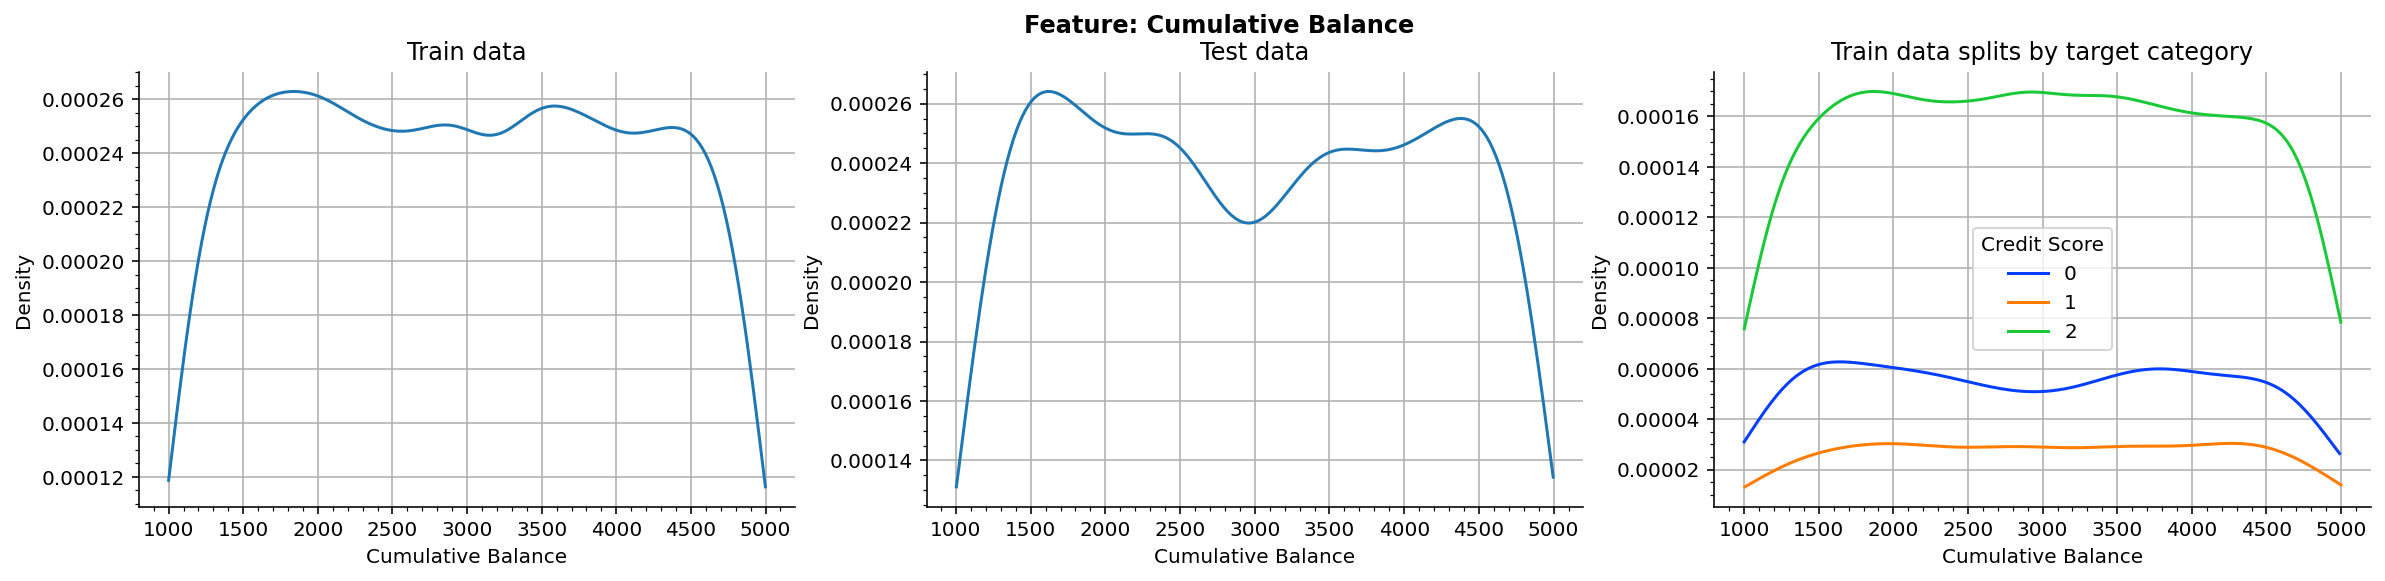


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1186.0,2949.8668,1165.4039,1000.0,1919.75,2949.0,3942.25,4990.0
1,600.0,3021.2583,1143.1555,1005.0,2047.00,2982.5,4039.00,4999.0
2,3372.0,2996.2248,1138.4557,1001.0,2018.00,2981.0,3971.25,4998.0


In [ ]:
explore_cont('Cumulative Balance')

### Cash Flow


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,5158.0,2565.5039,1413.3248,100.0,1361.0,2586.5,3793.75,4999.0
Test,1524.0,2512.9790,1407.7230,100.0,1304.0,2474.5,3734.00,4992.0


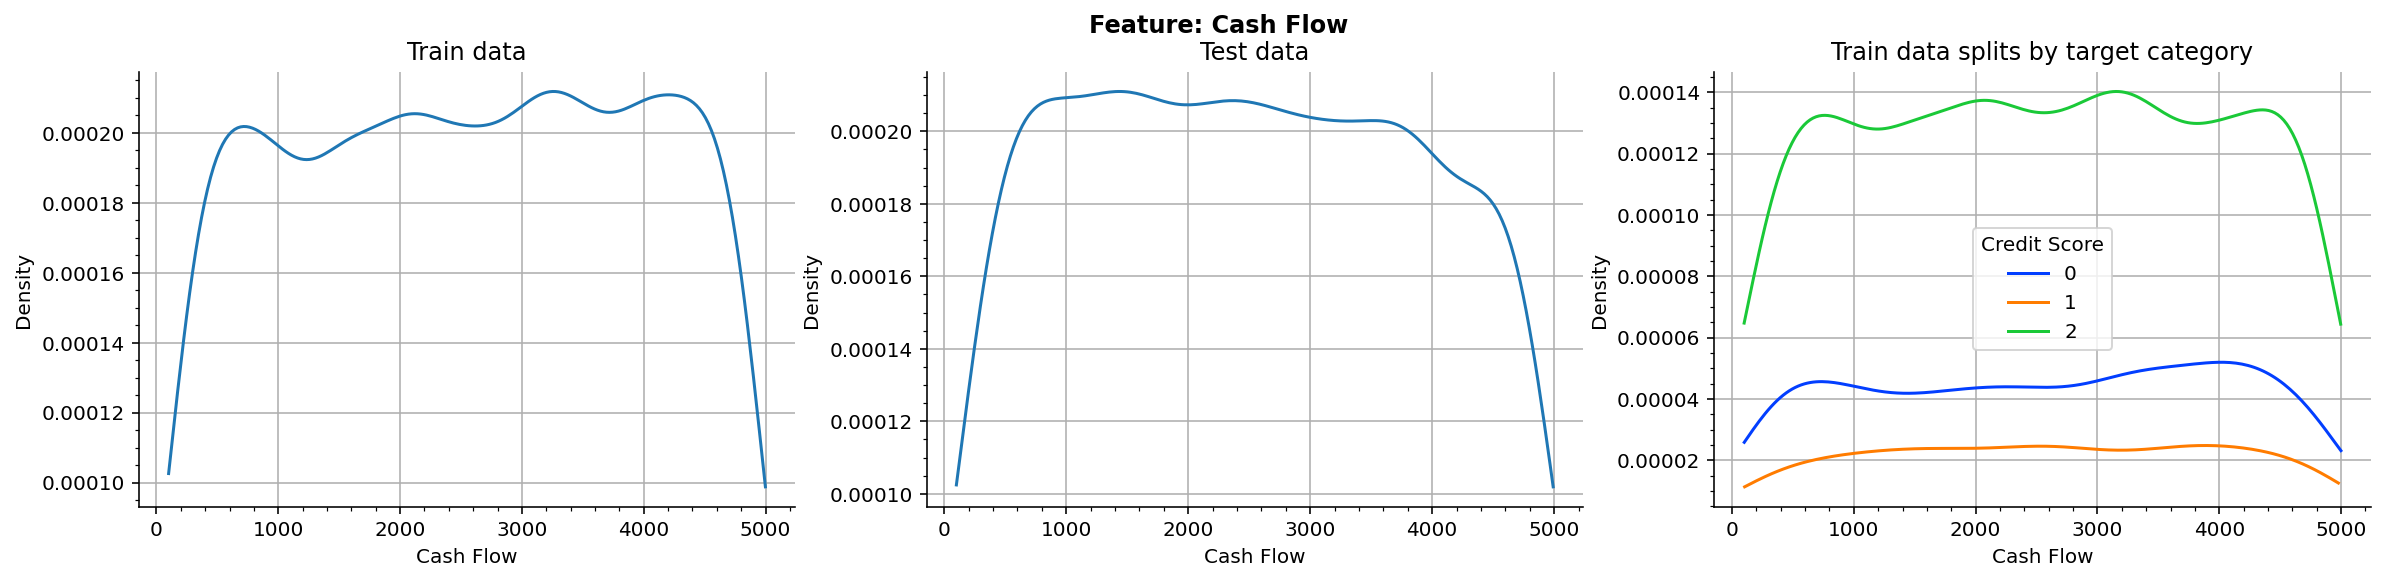


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Credit Score,,,,,,,,
0,1186.0,2582.5835,1438.9113,101.0,1318.25,2625.0,3848.75,4999.0
1,600.0,2587.1350,1409.1311,104.0,1404.50,2610.0,3791.25,4978.0
2,3372.0,2555.6477,1405.2894,100.0,1363.75,2563.5,3763.50,4997.0


In [ ]:
explore_cont('Cash Flow')

# Feature selection

In [ ]:
features = list(test.columns)

### Correlation (Kendall-Tau)

In [ ]:
def plot_corr_matrix(corr_df, size=12):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, fmt='.2f',
                linewidths=0.1)
    plt.show()

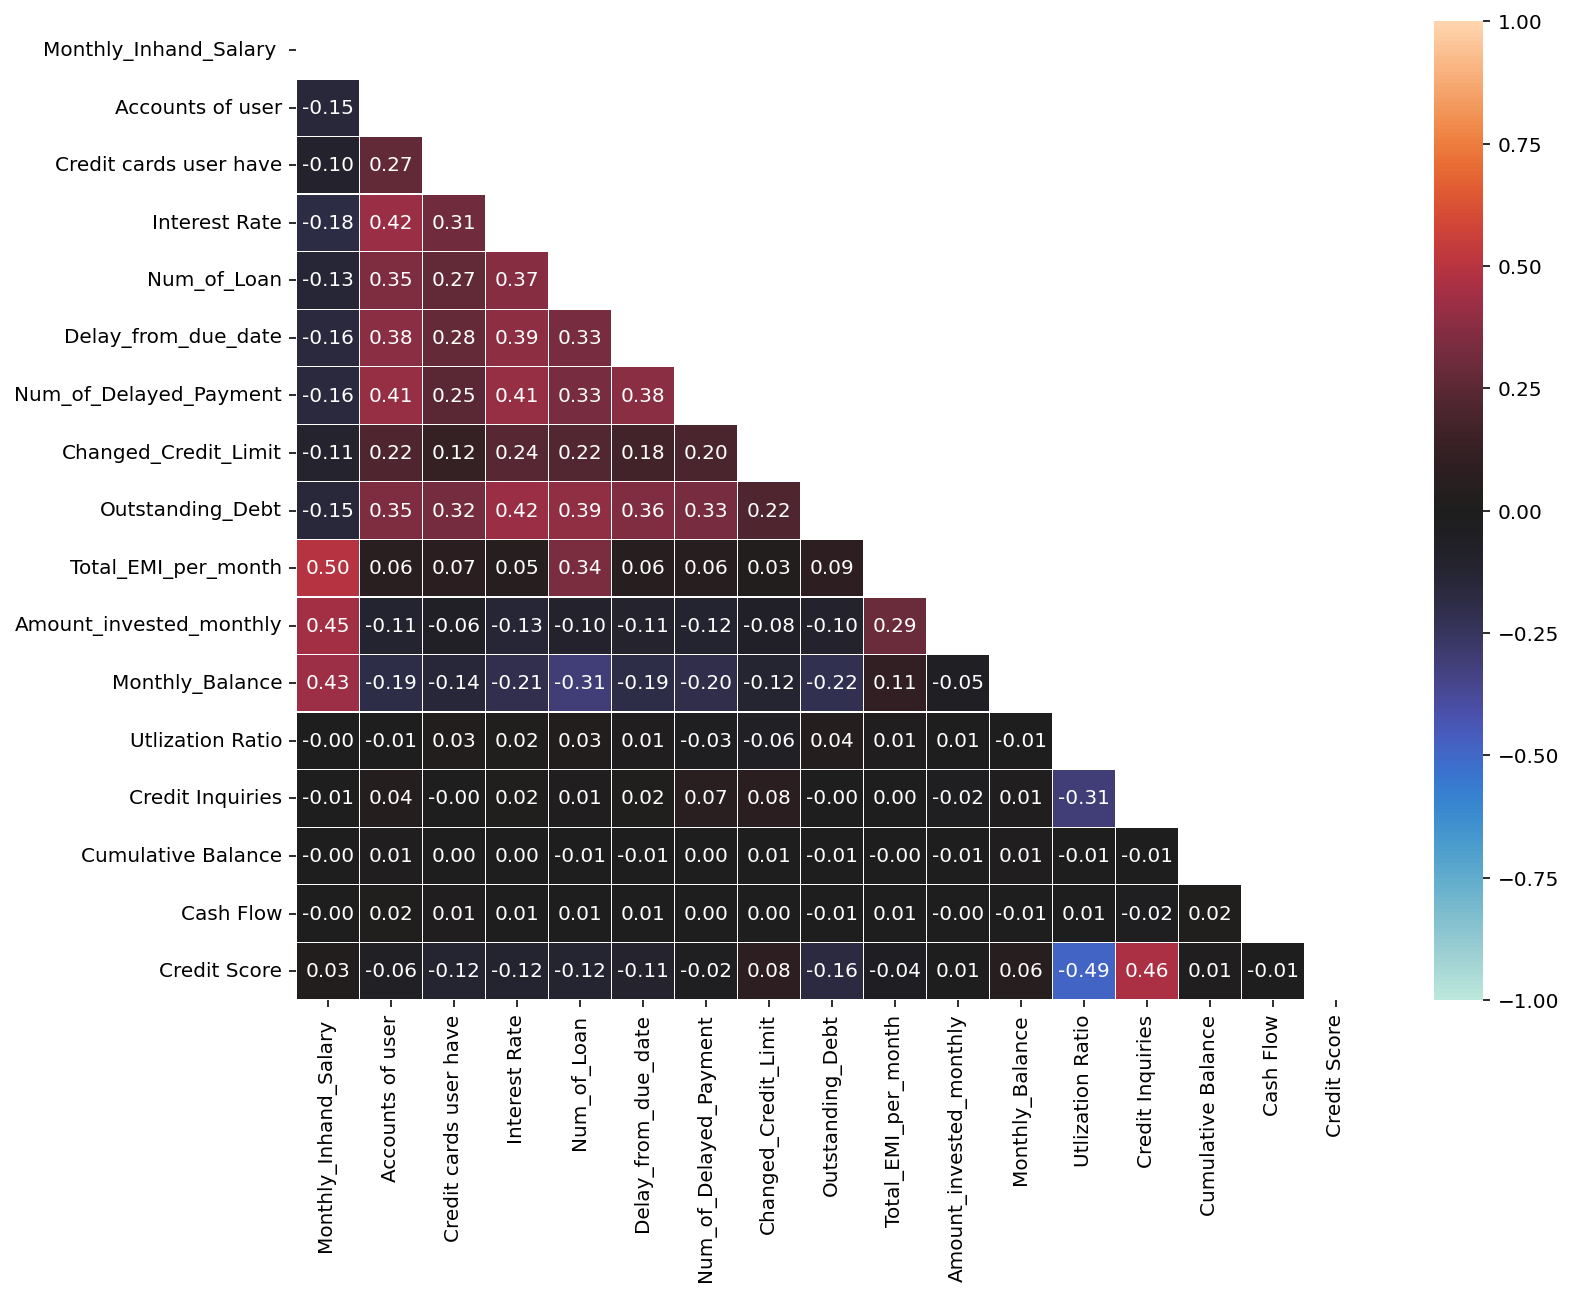

In [ ]:
corr_df = train.corr(method='kendall')
plot_corr_matrix(corr_df)

### ANOVA F-test

In [ ]:
anova_test = f_classif(train[features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=features
)

,f-statistic,p-value,accepted?
Monthly_Inhand_Salary,70.3245,7.3733e-31,True
Accounts of user,310.4488,4.9563e-128,True
Credit cards user have,351.6933,6.6304e-144,True
Interest Rate,525.7508,1.6091e-208,True
Num_of_Loan,247.6973,1.9334e-103,True
Delay_from_due_date,401.4212,9.4946e-163,True
Num_of_Delayed_Payment,322.7460,8.6854e-133,True
Changed_Credit_Limit,95.1125,2.7356e-41,True
Outstanding_Debt,313.4549,3.3931e-129,True
Total_EMI_per_month,7.5076,5.5492e-04,True


### Mutual Information

In [ ]:
mi_scores = mutual_info_classif(train[features], train[TARGET], random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
)

,mi_score
Monthly_Inhand_Salary,0.2495
Accounts of user,0.0607
Credit cards user have,0.0684
Interest Rate,0.1196
Num_of_Loan,0.0501
Delay_from_due_date,0.0880
Num_of_Delayed_Payment,0.0715
Changed_Credit_Limit,0.1747
Outstanding_Debt,0.2877
Total_EMI_per_month,0.2307


### ExtraTrees feature importances

In [ ]:
et = ExtraTreesClassifier(n_estimators=200, max_depth=7, n_jobs=-1, random_state=SEED)
et.fit(train[features], train[TARGET])

ExtraTreesClassifier(max_depth=7, n_estimators=200, n_jobs=-1,
                     random_state=2311)

In [ ]:
pd.DataFrame(
    data={'importance': et.feature_importances_},
    index=features
)

,importance
Monthly_Inhand_Salary,0.0044
Accounts of user,0.0190
Credit cards user have,0.0284
Interest Rate,0.0600
Num_of_Loan,0.0219
Delay_from_due_date,0.0334
Num_of_Delayed_Payment,0.0192
Changed_Credit_Limit,0.0132
Outstanding_Debt,0.0412
Total_EMI_per_month,0.0037


### Reduced features

In [ ]:
top_features = ['Utlization Ratio', 'Credit Inquiries']

mi_features = top_features + ['Monthly_Inhand_Salary ', 'Interest Rate', 
              'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month']

anova_features = top_features + ['Accounts of user', 'Credit cards user have', 
                 'Interest Rate', 'Num_of_Loan', 'Delay_from_due_date', 
                 'Num_of_Delayed_Payment', 'Outstanding_Debt']

# Baseline

In [ ]:
train = train.reset_index(drop=True)

In [ ]:
def cross_val_predict(data, model, n_splits=5):
    scores = {
        'Fold': [str(i) for i in range(n_splits)],
        'F1-micro': [],
        'F1-macro': [],
        'F1-weighted': []
    }
    test_preds = {}
    
    X, y, X_test = data

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        test_preds[f'fold{fold}'] = model.predict(X_test)

        f1micro = f1_score(y_val, val_preds, average='micro')
        scores['F1-micro'].append(f1micro)
        f1macro = f1_score(y_val, val_preds, average='macro')
        scores['F1-macro'].append(f1macro)
        f1weight = f1_score(y_val, val_preds, average='weighted')
        scores['F1-weighted'].append(f1weight)
        _ = gc.collect()

    scores['Fold'].append('Avg.')
    for metric in ['F1-micro', 'F1-macro', 'F1-weighted']:
        scores[metric].append(np.mean(scores[metric]))
    score_df = pd.DataFrame.from_dict(scores).set_index('Fold')
    display(score_df)

    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mode'] = test_preds.mode(axis=1)[0].astype('int')
    return test_preds

In [ ]:
model = ExtraTreesClassifier(n_estimators=250, max_depth=7, n_jobs=-1, random_state=SEED)

In [ ]:
%%time
test_preds_all = cross_val_predict(
    data=(train[features], train[TARGET], test[features]),
    model=model
)

,F1-micro,F1-macro,F1-weighted
Fold,,,
0,0.8905,0.8541,0.8854
1,0.8886,0.8492,0.8839
2,0.8769,0.8265,0.8713
3,0.8836,0.8491,0.8797
4,0.8739,0.8249,0.8685
Avg.,0.8827,0.8408,0.8778


CPU times: user 4.4 s, sys: 433 ms, total: 4.84 s
Wall time: 3.43 s


In [ ]:
%%time
test_preds_mi = cross_val_predict(
    data=(train[mi_features], train[TARGET], test[mi_features]),
    model=model
)

,F1-micro,F1-macro,F1-weighted
Fold,,,
0,0.8847,0.8395,0.8797
1,0.8934,0.8554,0.8896
2,0.8808,0.8301,0.8762
3,0.8826,0.8431,0.8786
4,0.8758,0.8280,0.8712
Avg.,0.8835,0.8392,0.8791


CPU times: user 3.9 s, sys: 455 ms, total: 4.35 s
Wall time: 3.23 s


In [ ]:
%%time
test_preds_anova = cross_val_predict(
    data=(train[anova_features], train[TARGET], test[anova_features]),
    model=model
)

,F1-micro,F1-macro,F1-weighted
Fold,,,
0,0.9041,0.8703,0.9011
1,0.8944,0.8624,0.8919
2,0.8847,0.8364,0.8811
3,0.8914,0.8598,0.8891
4,0.8904,0.8562,0.8876
Avg.,0.8930,0.8570,0.8902


CPU times: user 4.2 s, sys: 289 ms, total: 4.49 s
Wall time: 3.88 s


In [ ]:
%%time
test_preds_top = cross_val_predict(
    data=(train[top_features], train[TARGET], test[top_features]),
    model=model
)

,F1-micro,F1-macro,F1-weighted
Fold,,,
0,0.9002,0.8633,0.8976
1,0.8915,0.8397,0.8891
2,0.8798,0.8234,0.8768
3,0.8758,0.8287,0.8744
4,0.8855,0.8344,0.8826
Avg.,0.8866,0.8379,0.8841


CPU times: user 3.53 s, sys: 368 ms, total: 3.9 s
Wall time: 3.12 s


In [ ]:
train_og = pd.read_csv(f'{DATA_URL}/train.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
train_og[TARGET] = train_og[TARGET].replace(label_mapping)

In [ ]:
%%time
test_preds_og_all = cross_val_predict(
    data=(train_og[features], train_og[TARGET], test[features]),
    model=model
)

,F1-micro,F1-macro,F1-weighted
Fold,,,
0,0.8638,0.8107,0.8576
1,0.8712,0.8275,0.8641
2,0.8663,0.8161,0.8588
3,0.8852,0.8494,0.8803
4,0.8892,0.8485,0.8840
Avg.,0.8751,0.8305,0.8690


CPU times: user 4.44 s, sys: 441 ms, total: 4.88 s
Wall time: 3.44 s


**Dataset with outliers clipped performs better.**